## Imports

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np

from src.database import *
from src.nist import get_reference_NIST_values, get_NIST_ids
from src.tools import calc_error

import matplotlib.pyplot as plt
plt.style.use('custom_matplotlibrc')
plt.rcParams["figure.figsize"] = (10,10)
fig_id = 0

## Configurations

In [2]:
database_path_barral = Path('databases/3T_NIST_T1maps_database.pkl')
database_path_general = Path('databases/3T_NIST_T1maps_general_fitting_model_database.pkl')


output_folder = Path("plots/07_alldatasets_scatter_NIST_singleplots_model_comparison/")

estimate_type = 'median' # median or mean

## Define functions

In [3]:
def plot_single_scatter(x, y1, y2, y1_std, y2_std,
                        title, x_label, y_label,
                        file_prefix, folder_path, fig_id,
                        y_type='linear',
                        labels=None):
    if y_type is 'linear':
        plt.errorbar(x,y1, y1_std, fmt='o', solid_capstyle='projecting')
        plt.errorbar(x,y2, y2_std, color='#FF6961', fmt='o', solid_capstyle='projecting')
        plt.legend(tuple(labels))


        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0, ymax=2500)
        ax.set_xlim(xmin=0, xmax=2500)
    if y_type is 'log':
        plt.loglog(x,y1,'o')
        plt.loglog(x,y2, 'o', color='#FF6961')
        plt.legend(tuple(labels))

        ax = plt.gca()
        ax.set_ylim(ymin=20, ymax=2500)
        ax.set_xlim(xmin=20, xmax=2500)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y1), fmt='o', solid_capstyle='projecting')
        plt.errorbar(x,calc_error(x,y2), color='#FF6961', fmt='o', solid_capstyle='projecting')
        plt.legend(tuple(labels))

        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
        ax.set_ylim(ymin=-100, ymax=100)
        ax.set_xlim(xmin=0, xmax=2500)
        ax.set_ylim(ymin=-100, ymax=100)
        
    plt.title(title, fontsize=30)
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)

    fig = plt.gcf()
    

    folder_path.mkdir(parents=True, exist_ok=True)

    if fig_id<10:
        filename = "0" + str(fig_id) + "_" + file_prefix
    else:
        filename = str(fig_id) + "_" + file_prefix


    fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
    fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
    fig_id = fig_id + 1
    plt.show()
    return fig_id

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/1763959621.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if y_type is 'linear':
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/1763959621.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if y_type is 'log':
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/1763959621.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if y_type is 'error_t1':


## Load databases

In [4]:
df_barral = pd.read_pickle(database_path_barral)
df_general = pd.read_pickle(database_path_general)

## Initialize variables, store mean and standard deviations of T1 in the ROIs

In [5]:
dataset_estimate_barral = np.zeros((1,14))
dataset_std_barral = np.zeros((1,14))
version = np.array([])
index_id = np.array([])
ref_values = np.zeros((1,14))


ii=0
for index, row in df_barral.iterrows():
    if type(df_barral.loc[index]['T1 - NIST sphere 1']) is np.ndarray:
        index_id = np.append(index_id, index)
        version = np.append(version,df_barral.loc[index]['phantom serial number'])
        if version[ii] is None:
            version[ii] = 999 # Missing version, only known case is one where we have version > 42 right now.

        if ii==0:
            ref_values = get_reference_NIST_values(version[ii])
        else:
            ref_values = np.vstack((ref_values, get_reference_NIST_values(version[ii])))
        
        tmp_dataset_estimate = np.array([])
        tmp_dataset_std = np.array([])

        for key in get_NIST_ids():
            if estimate_type is 'mean':
                tmp_dataset_estimate = np.append(tmp_dataset_estimate, np.mean(df_barral.loc[index][key]))
            elif estimate_type is 'median':
                tmp_dataset_estimate = np.append(tmp_dataset_estimate, np.median(df_barral.loc[index][key]))
            else:
                Exception('Unsupported dataset estimate type.')

            tmp_dataset_std = np.append(tmp_dataset_std, np.std(df_barral.loc[index][key]))

        if ii==0:
            dataset_estimate_barral = tmp_dataset_estimate  
            dataset_std_barral = tmp_dataset_std
        else:
            dataset_estimate_barral = np.vstack((dataset_estimate_barral, tmp_dataset_estimate))
            dataset_std_barral = np.vstack((dataset_std_barral, tmp_dataset_std))

        ii=ii+1


<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/446237749.py:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if estimate_type is 'mean':
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/446237749.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif estimate_type is 'median':


In [6]:
dataset_estimate_general = np.zeros((1,14))
dataset_std_general = np.zeros((1,14))
version = np.array([])
index_id = np.array([])
ref_values = np.zeros((1,14))


ii=0
for index, row in df_general.iterrows():
    if type(df_general.loc[index]['T1 - NIST sphere 1']) is np.ndarray:
        index_id = np.append(index_id, index)
        version = np.append(version,df_general.loc[index]['phantom serial number'])
        if version[ii] is None:
            version[ii] = 999 # Missing version, only known case is one where we have version > 42 right now.

        if ii==0:
            ref_values = get_reference_NIST_values(version[ii])
        else:
            ref_values = np.vstack((ref_values, get_reference_NIST_values(version[ii])))
        
        tmp_dataset_estimate = np.array([])
        tmp_dataset_std = np.array([])

        for key in get_NIST_ids():
            if estimate_type is 'mean':
                tmp_dataset_estimate = np.append(tmp_dataset_estimate, np.mean(df_general.loc[index][key]))
            elif estimate_type is 'median':
                tmp_dataset_estimate = np.append(tmp_dataset_estimate, np.median(df_general.loc[index][key]))
            else:
                Exception('Unsupported dataset estimate type.')

            tmp_dataset_std = np.append(tmp_dataset_std, np.std(df_general.loc[index][key]))

        if ii==0:
            dataset_estimate_general = tmp_dataset_estimate  
            dataset_std = tmp_dataset_std
        else:
            dataset_estimate_general = np.vstack((dataset_estimate_general, tmp_dataset_estimate))
            dataset_std_general = np.vstack((dataset_std_general, tmp_dataset_std))

        ii=ii+1



<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/1401764464.py:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if estimate_type is 'mean':
/var/folders/l1/1xswjffd73l8yp7dd7pq9lyw0000gn/T/ipykernel_57406/1401764464.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif estimate_type is 'median':


## Setup for plots

In [7]:
fig_id = 0
dims=ref_values.shape
file_prefix = 'alldatasets'

## Plot figures

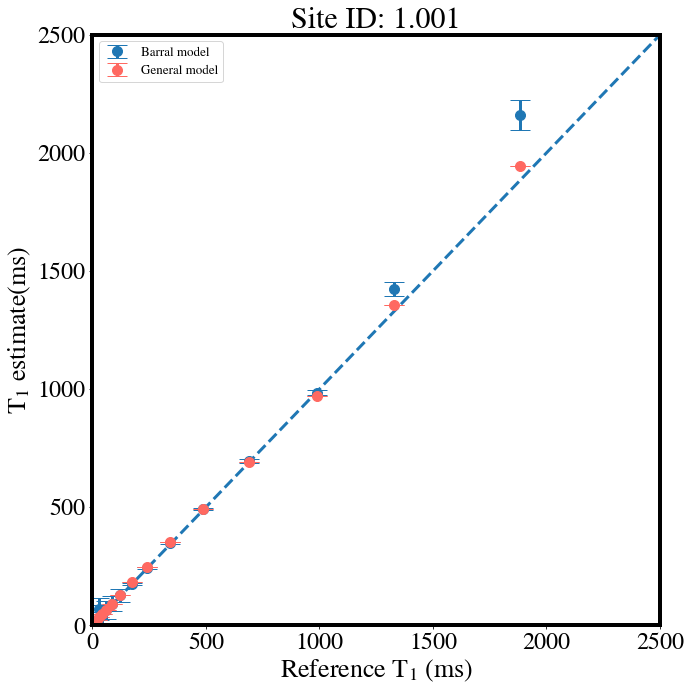

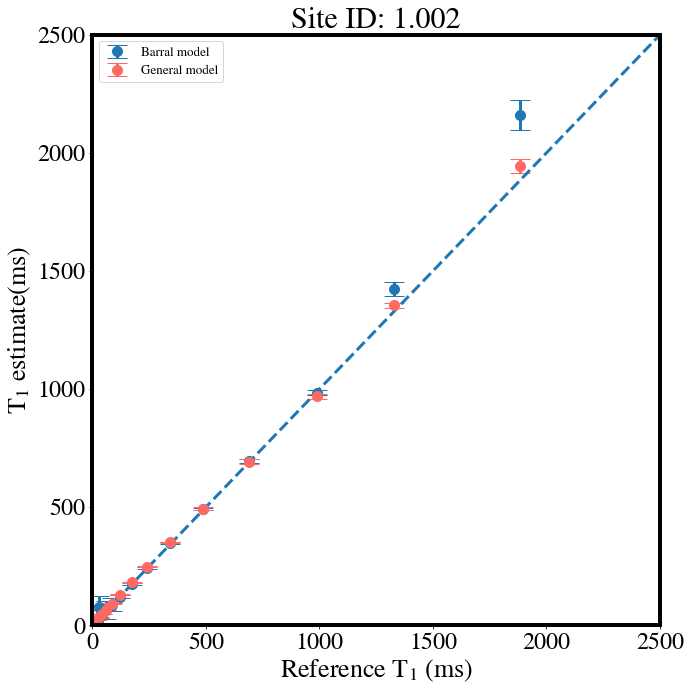

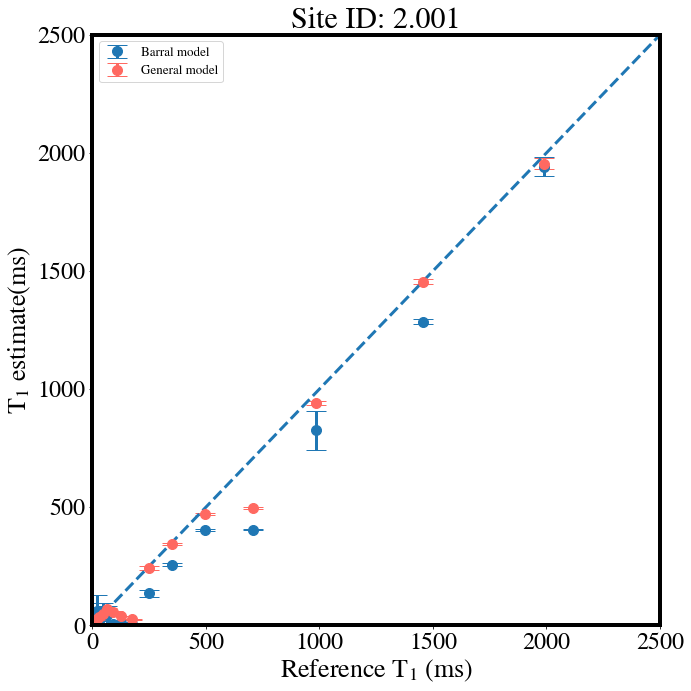

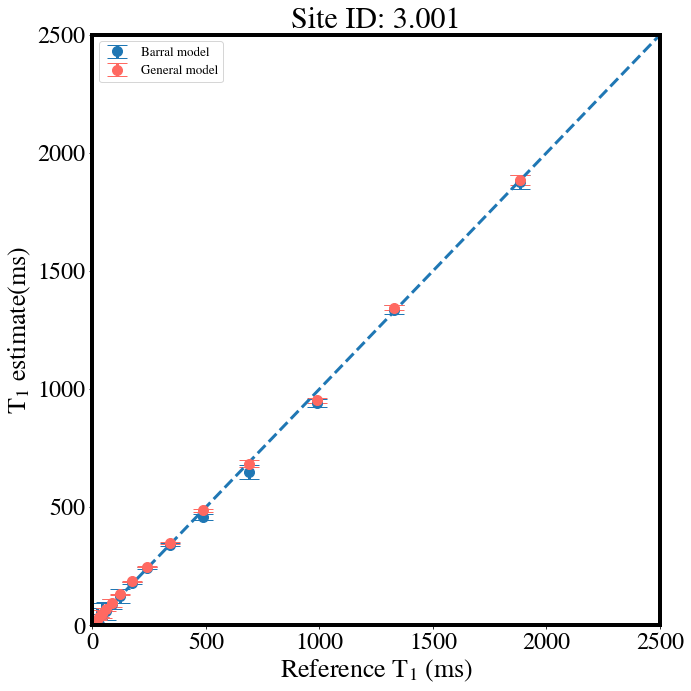

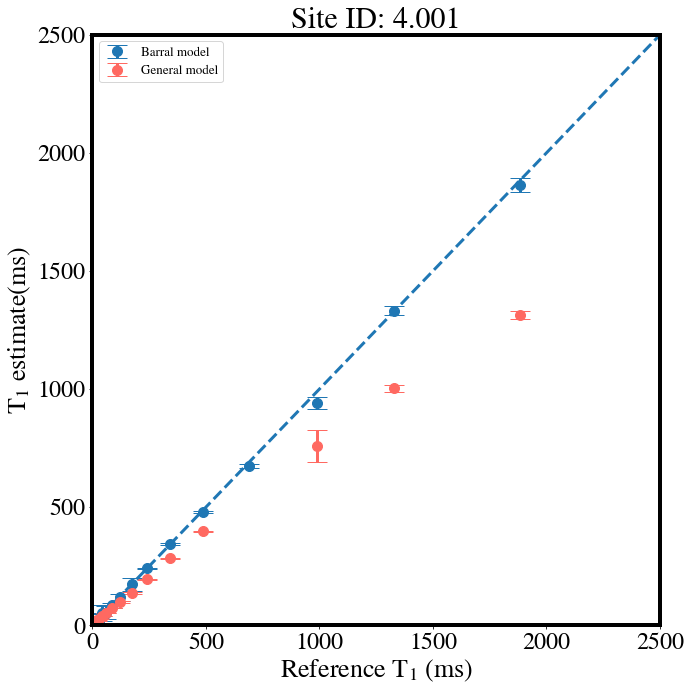

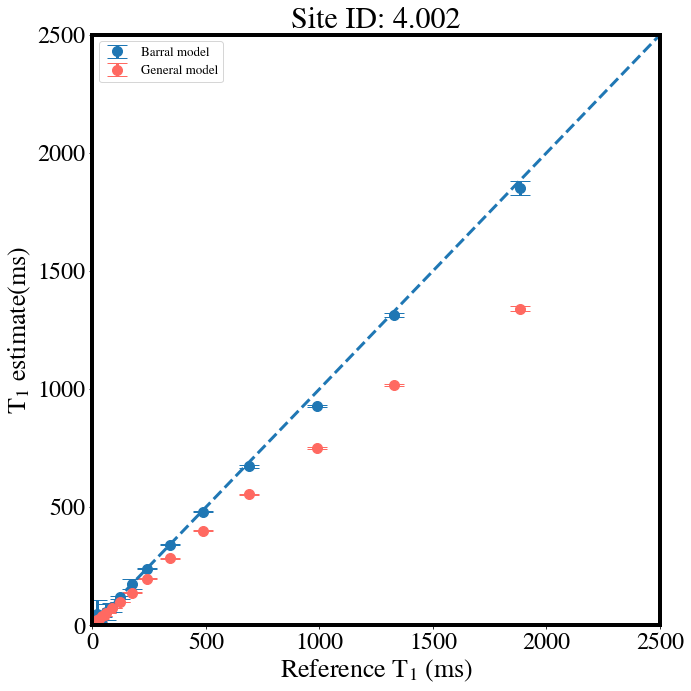

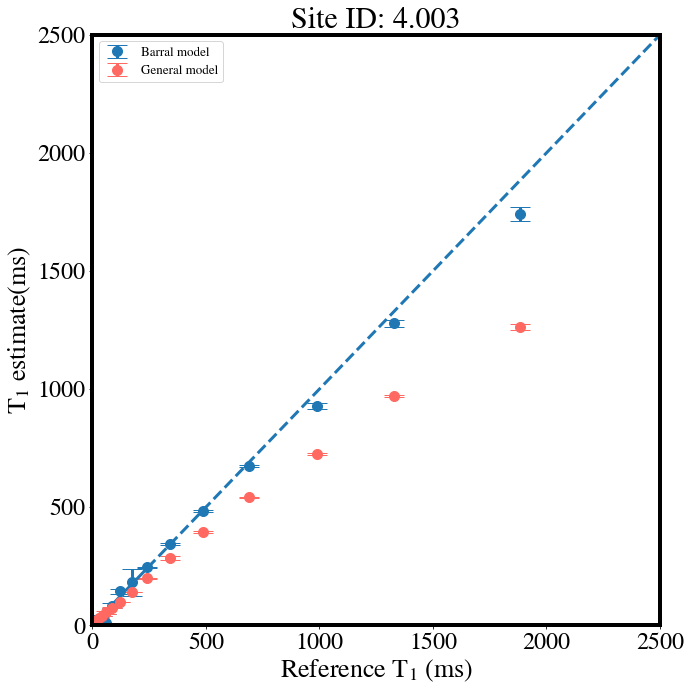

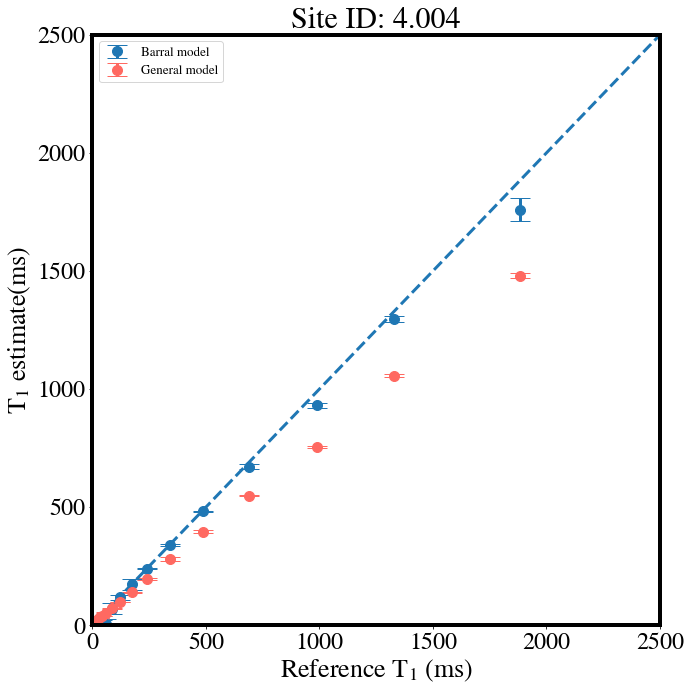

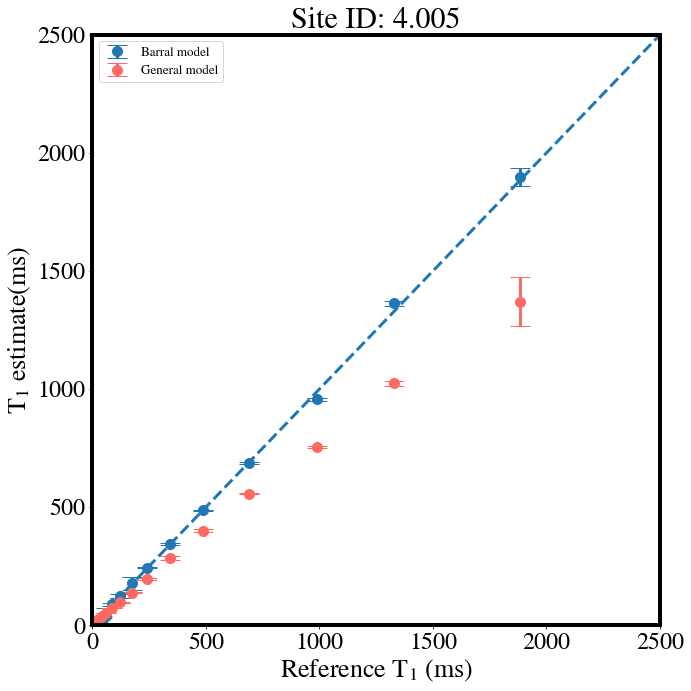

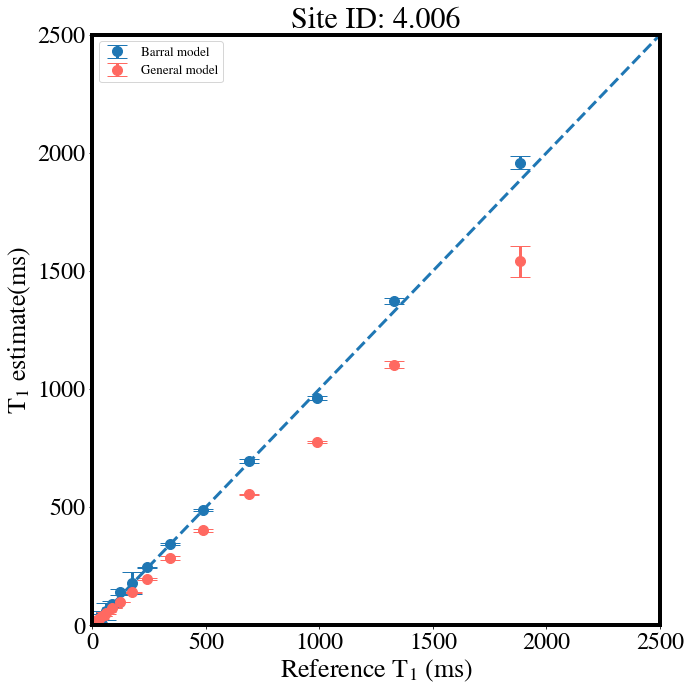

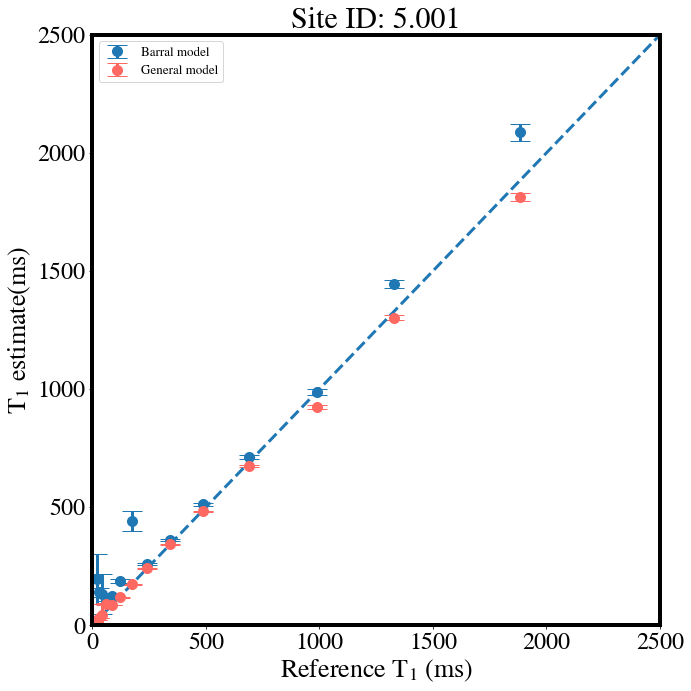

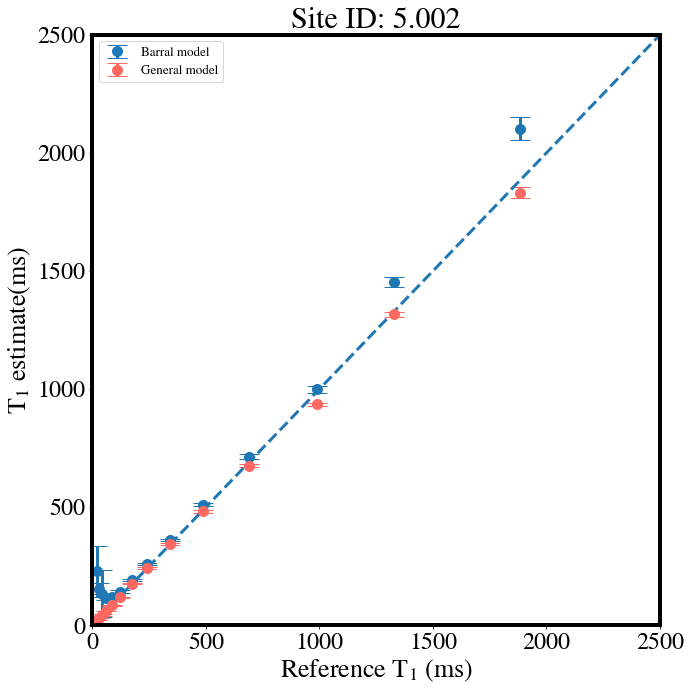

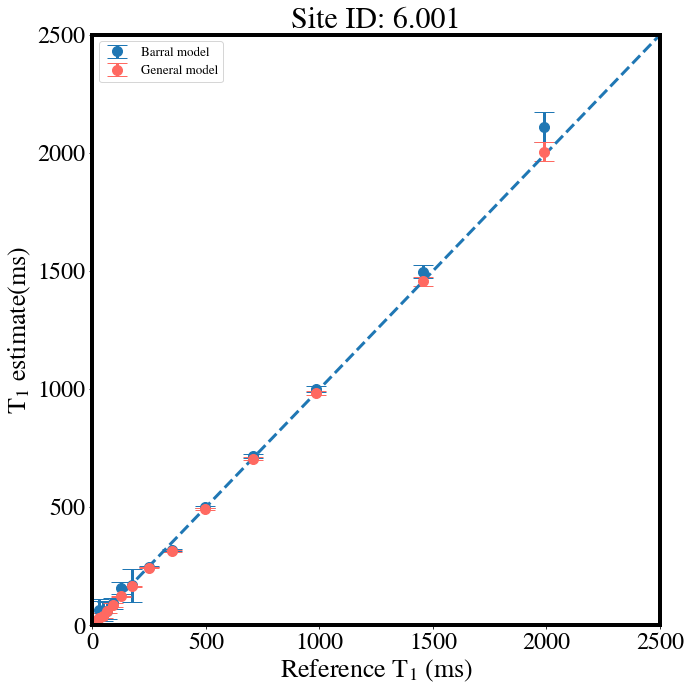

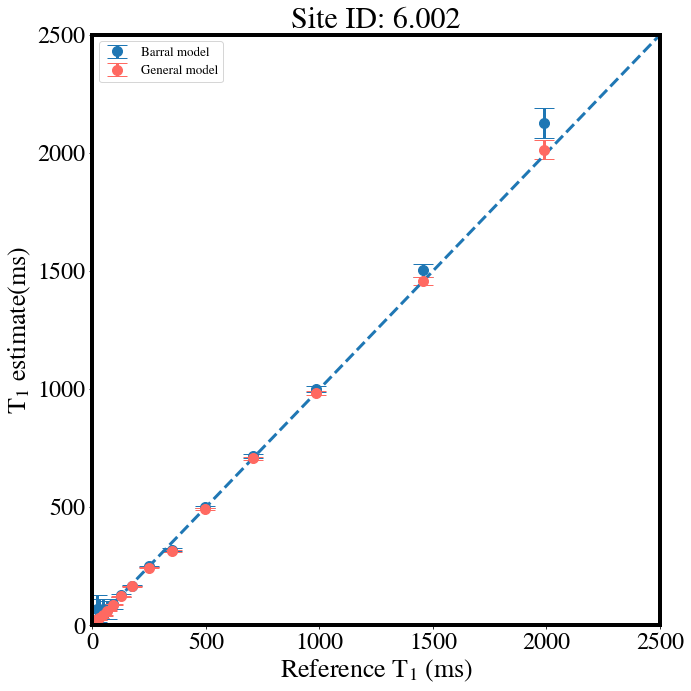

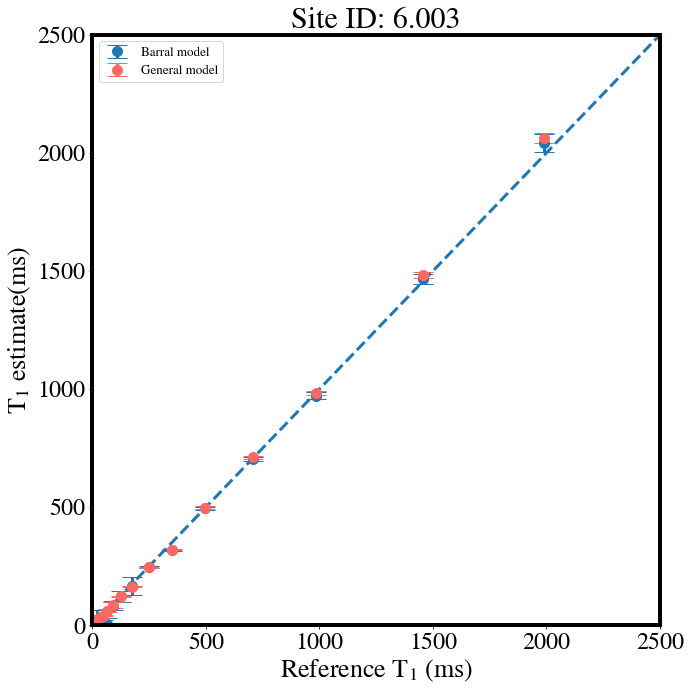

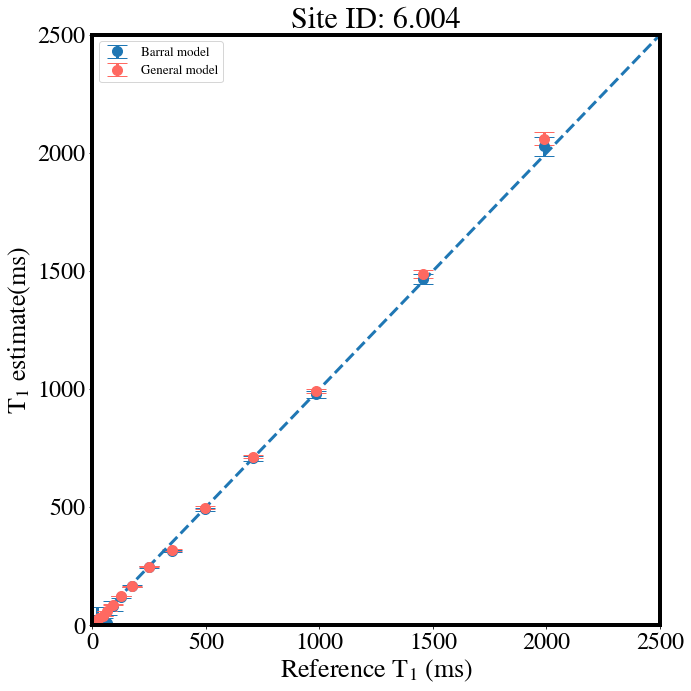

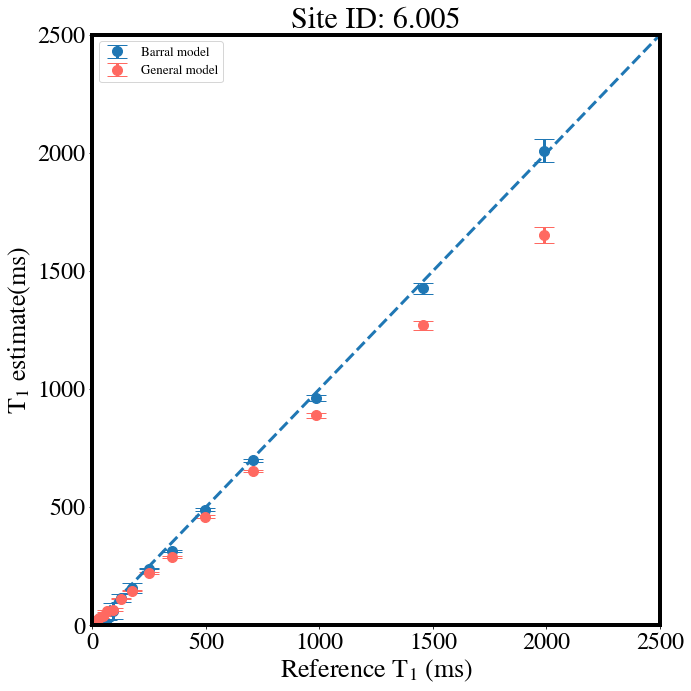

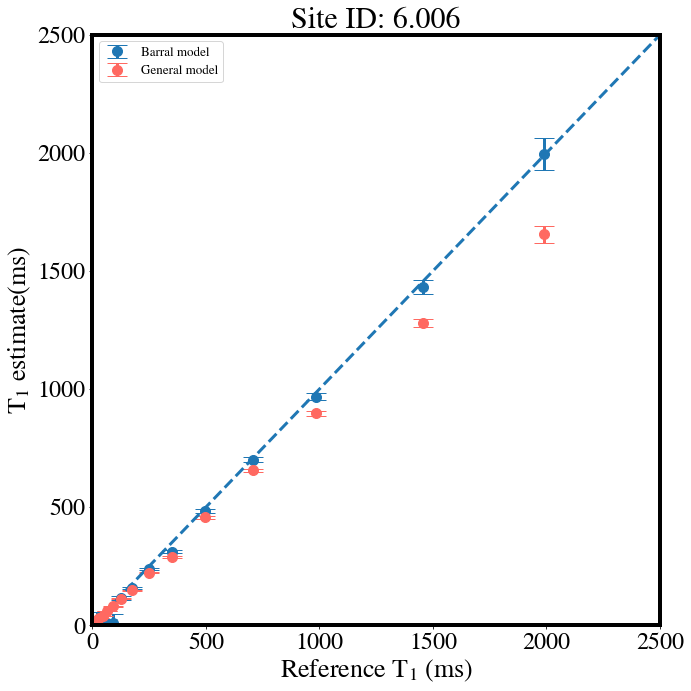

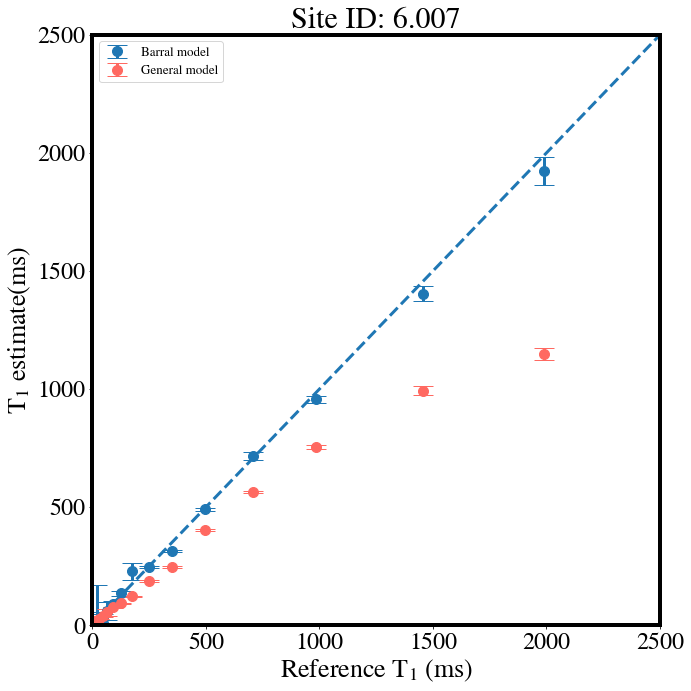

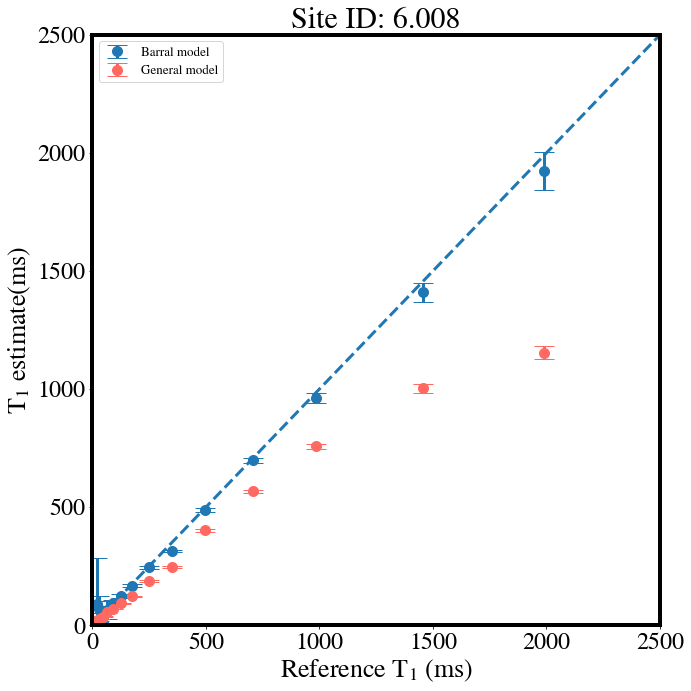

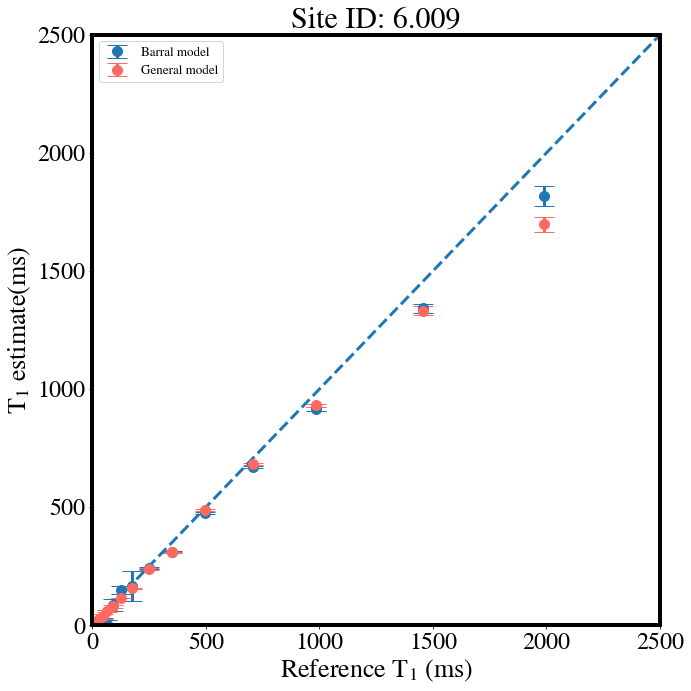

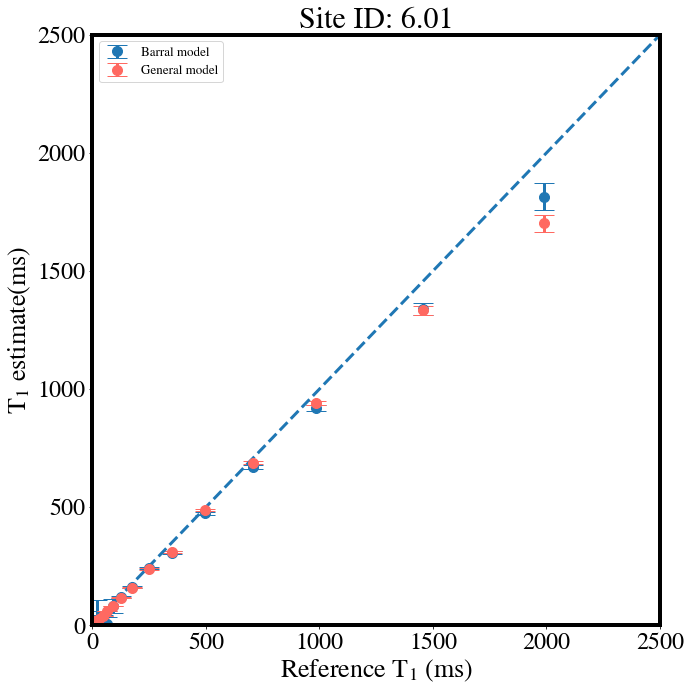

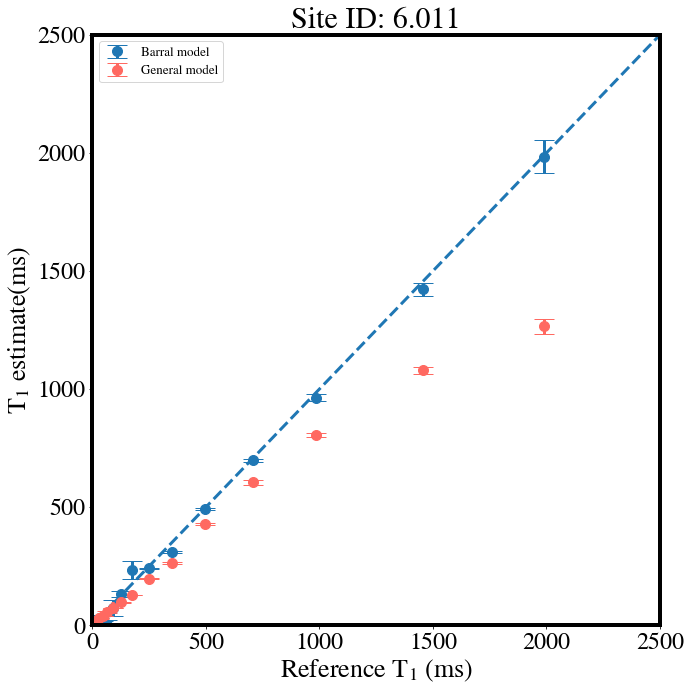

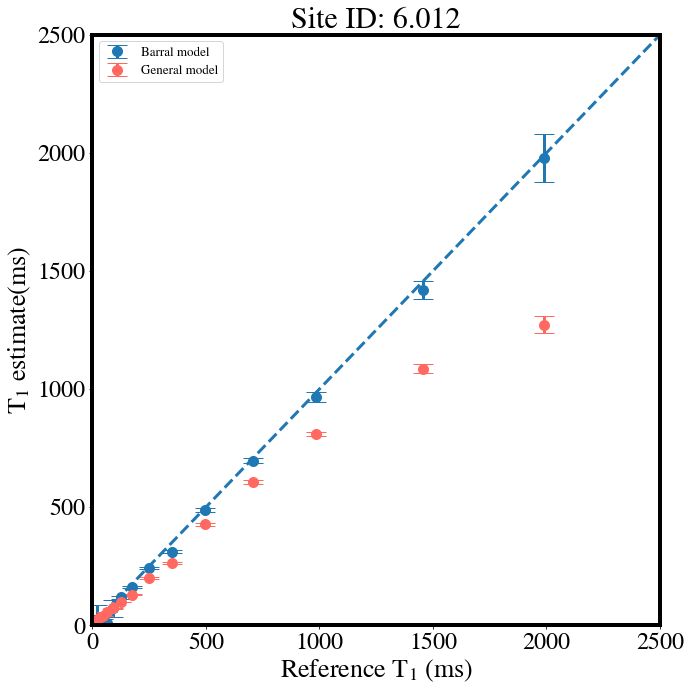

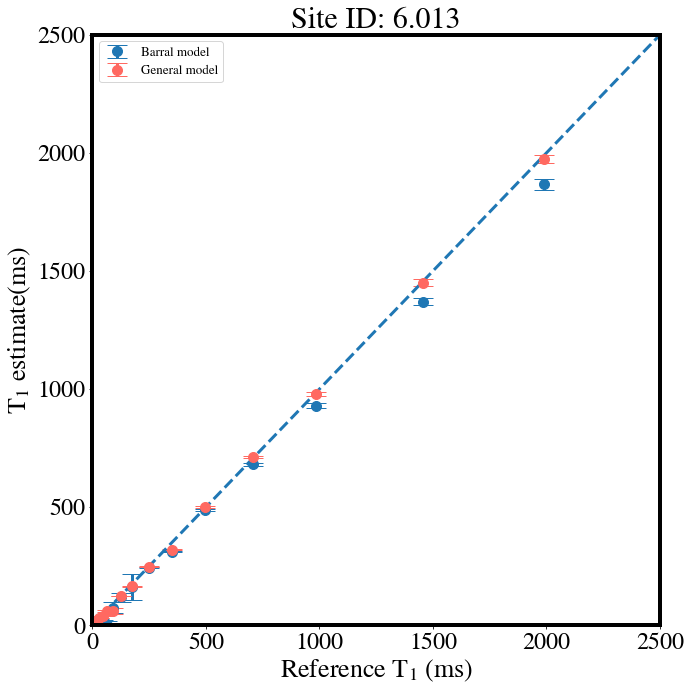

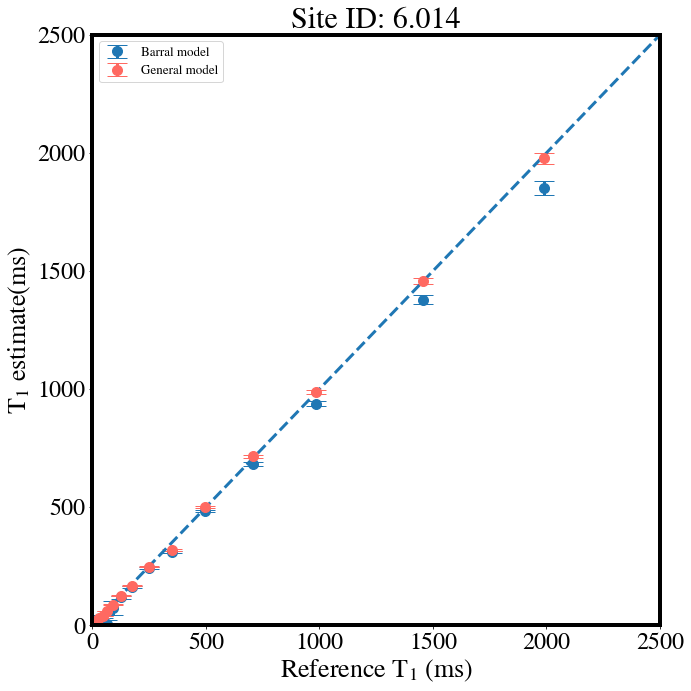

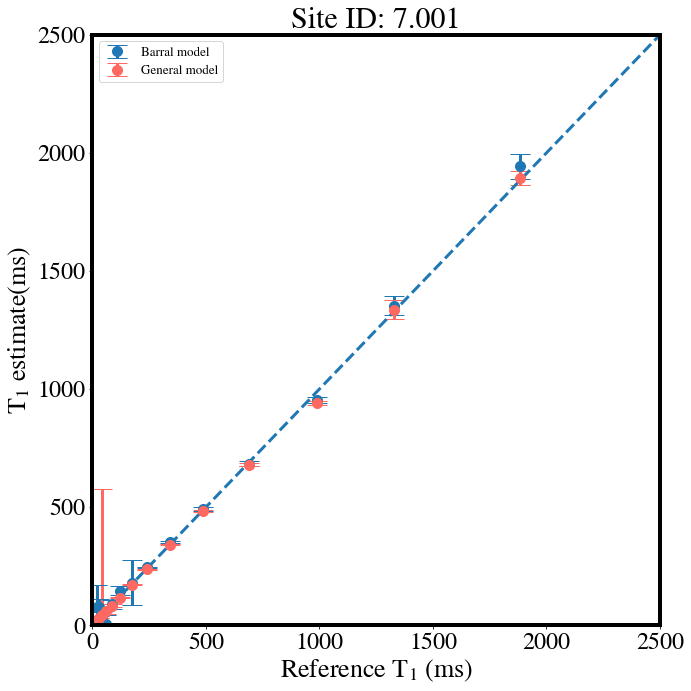

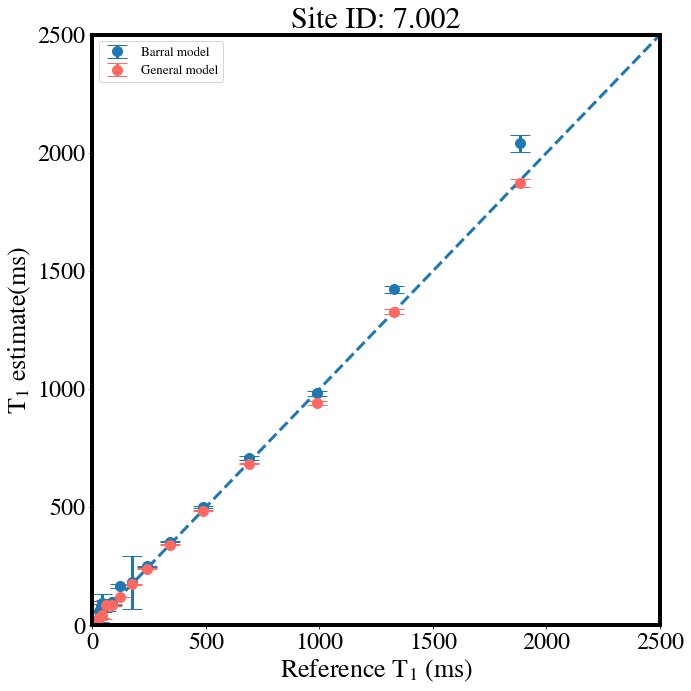

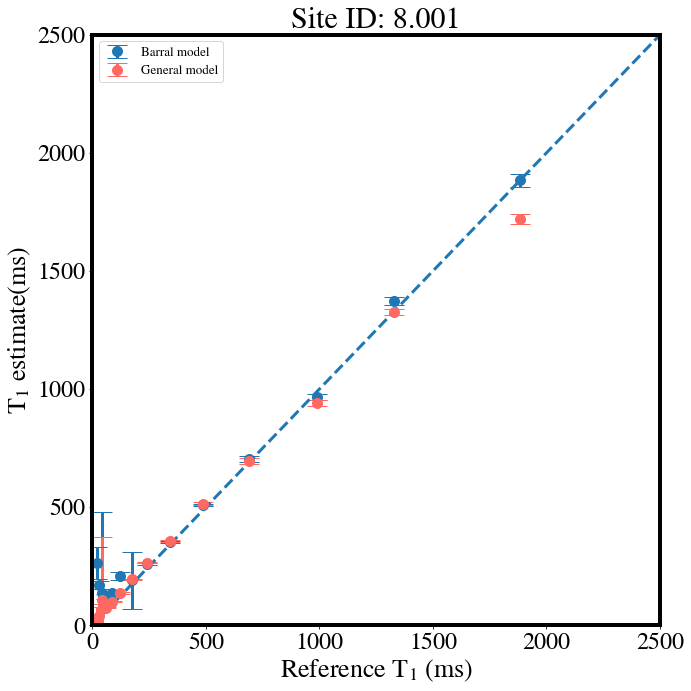

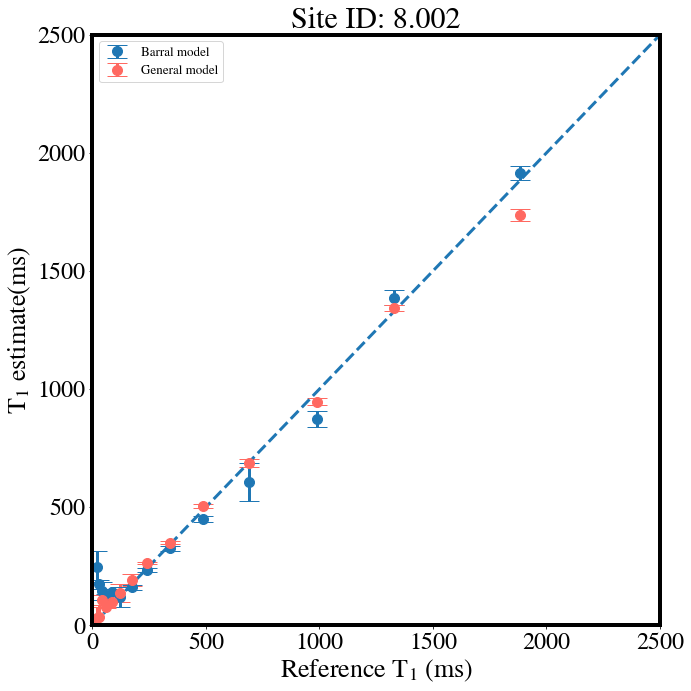

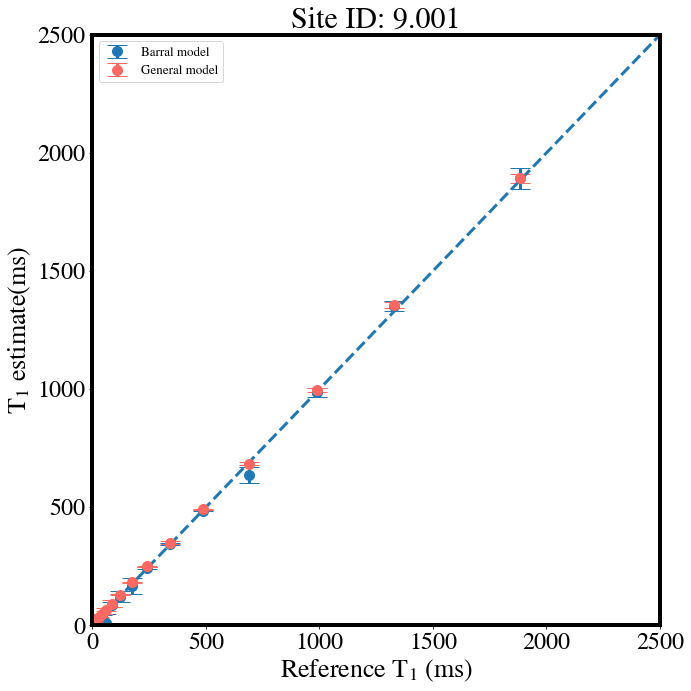

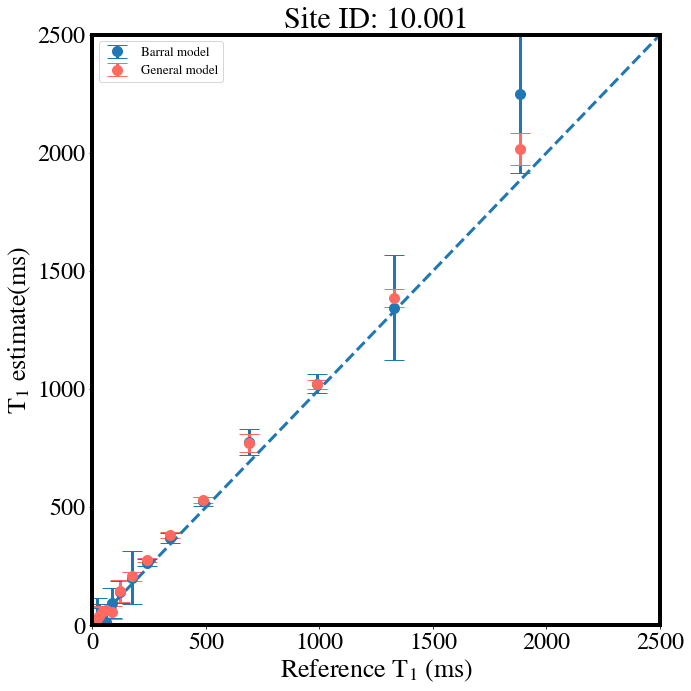

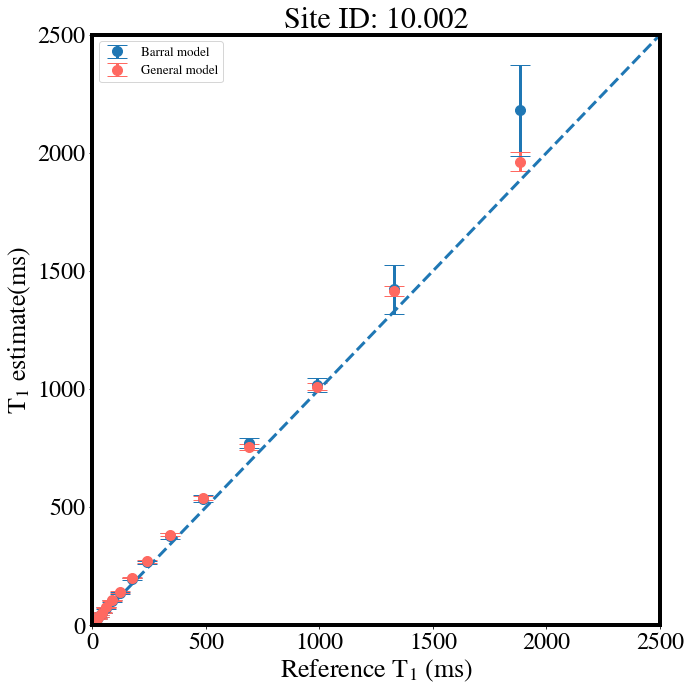

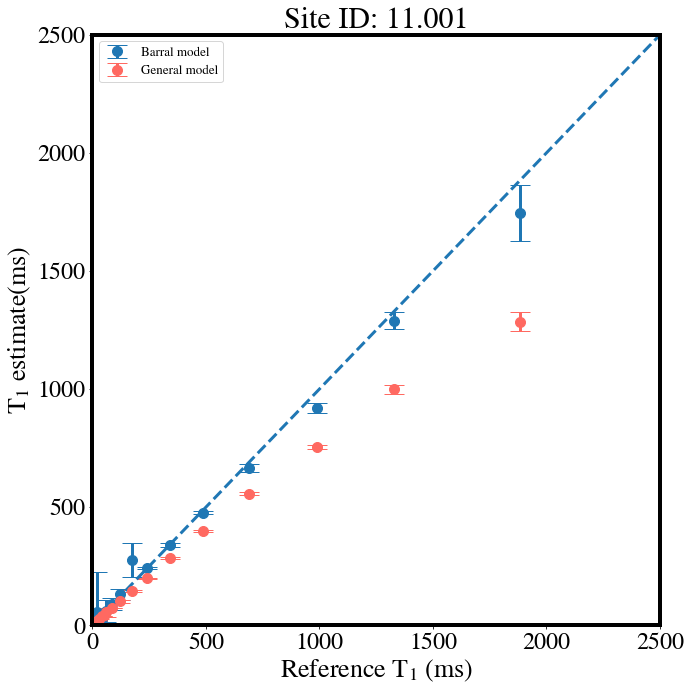

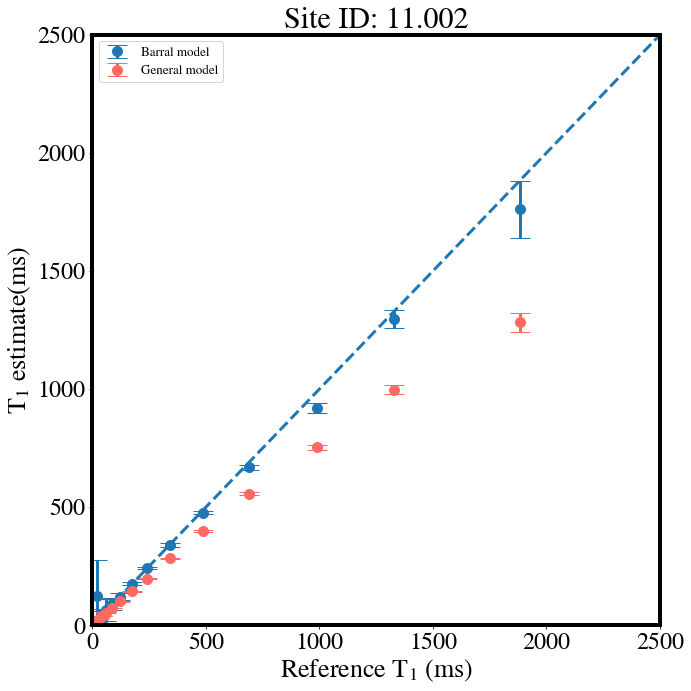

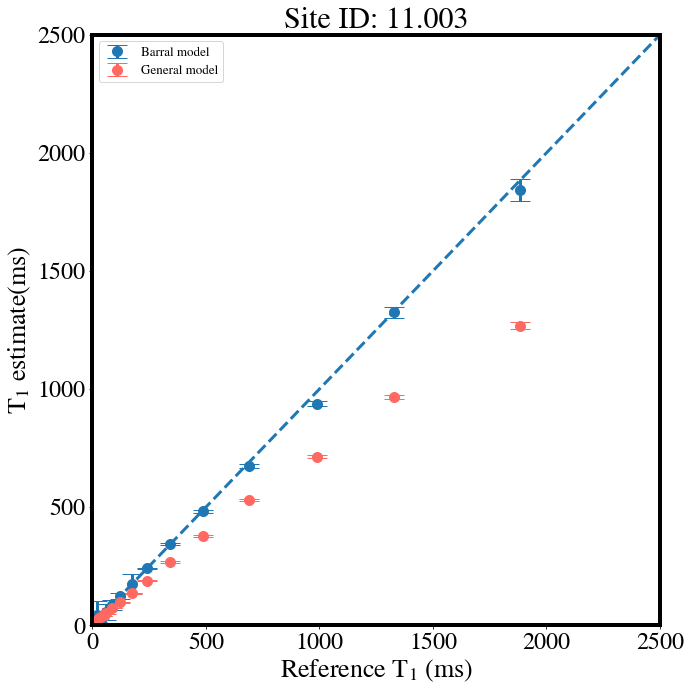

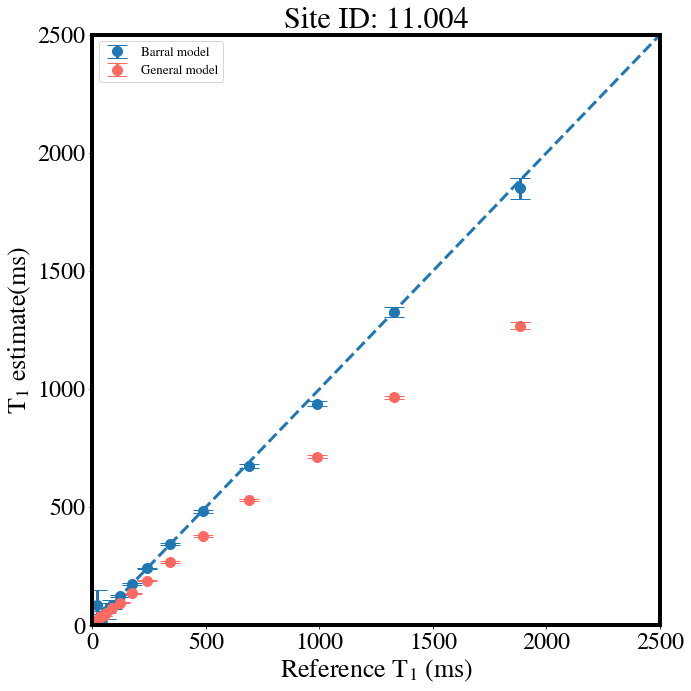

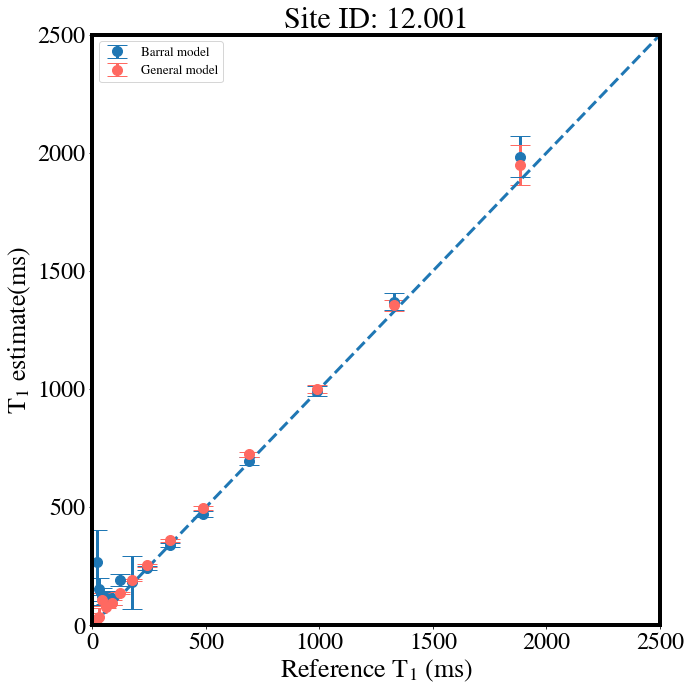

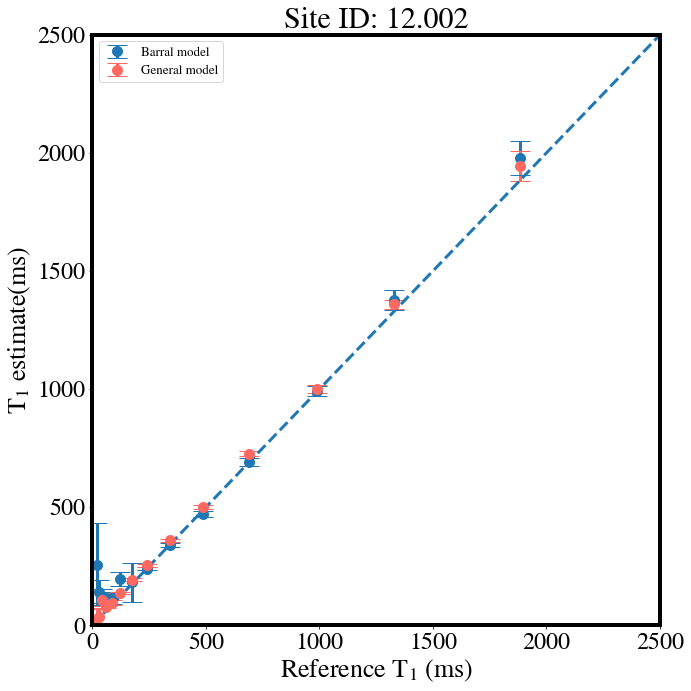

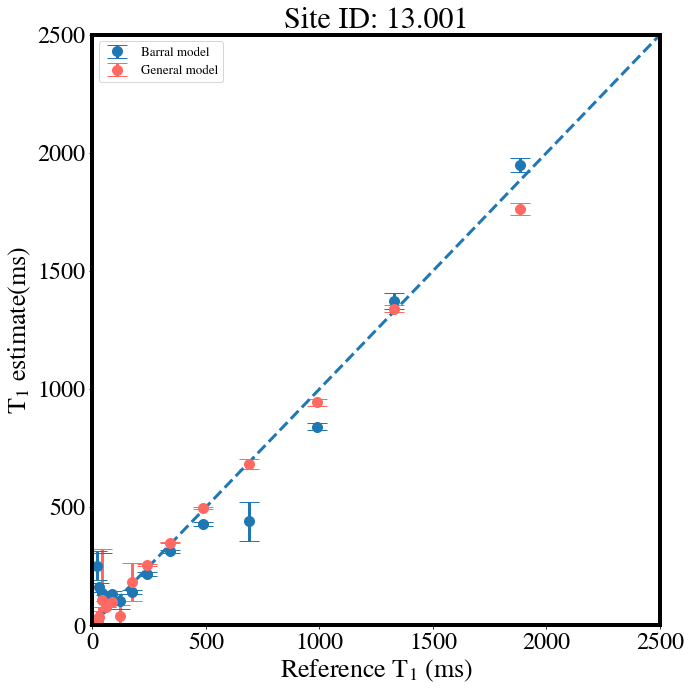

In [8]:
y_type = 'linear'
title = 'Linear axes'


for ii in range(dims[0]):

    fig_id = plot_single_scatter(x=ref_values[ii,:],
                                 y1=dataset_estimate_barral[ii,:],
                                 y2=dataset_estimate_general[ii,:],
                                 y1_std=dataset_std_barral[ii,:],
                                 y2_std=dataset_std_general[ii,:],
                                 title='Site ID: '+ str(index_id[ii]),
                                 x_label='Reference T$_1$ (ms)',
                                 y_label="T$_1$ estimate(ms)",
                                 file_prefix=('linear_' + str(index_id[ii])),
                                 folder_path=output_folder,
                                 fig_id=fig_id,
                                 y_type='linear',
                                 labels=['Barral model', 'General model'])

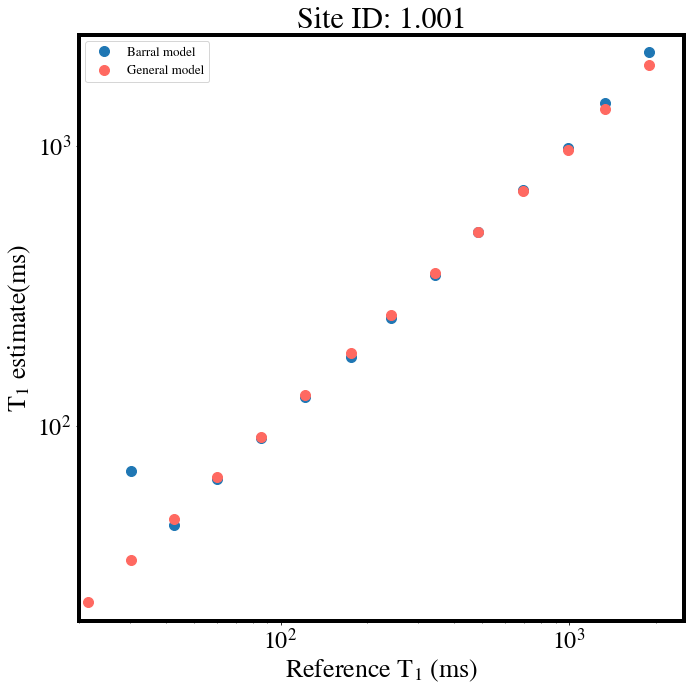

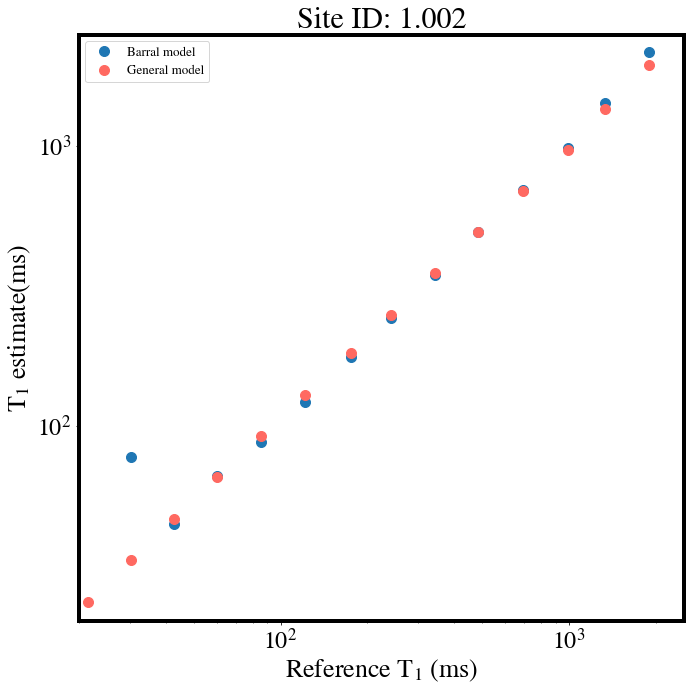

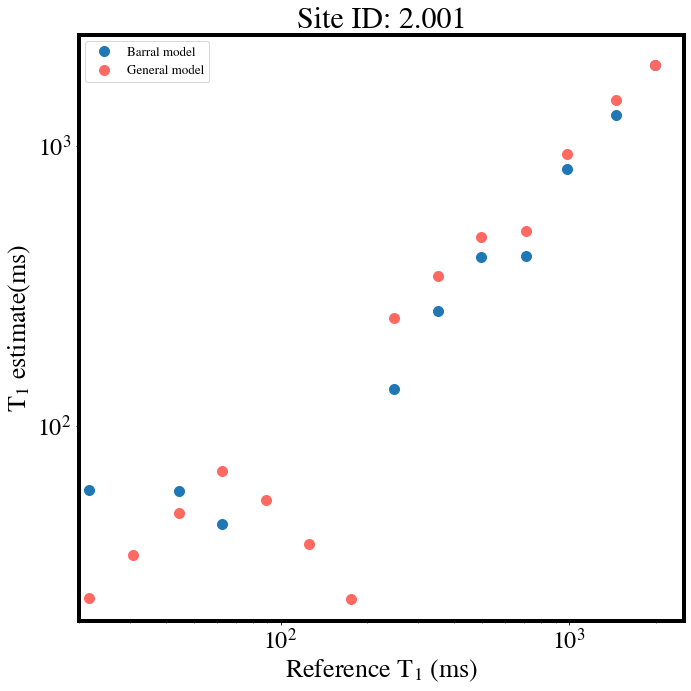

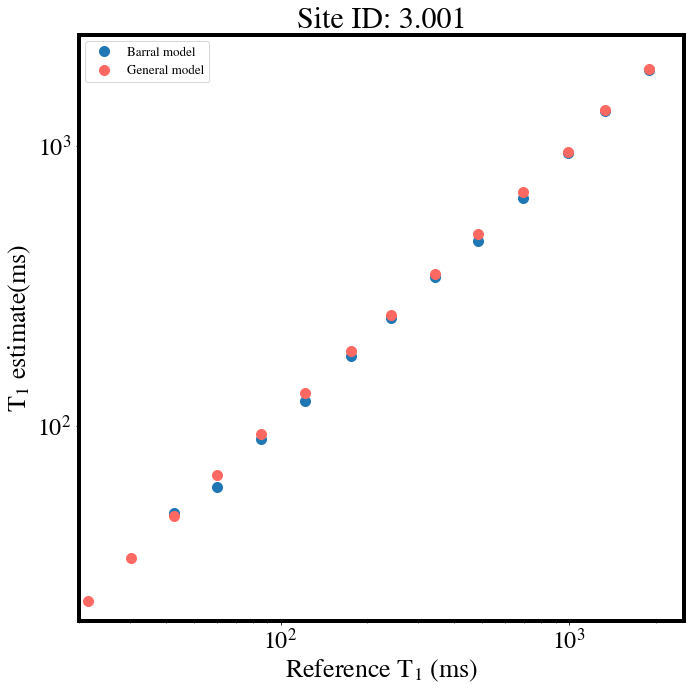

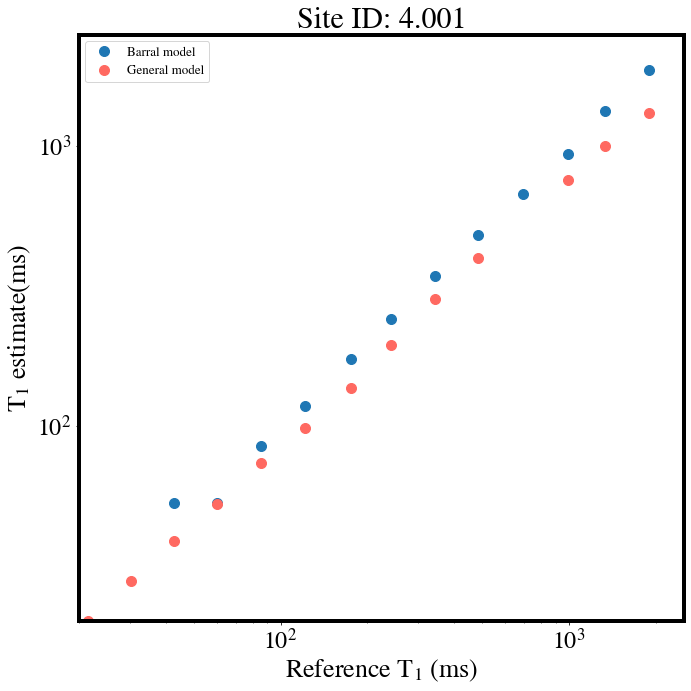

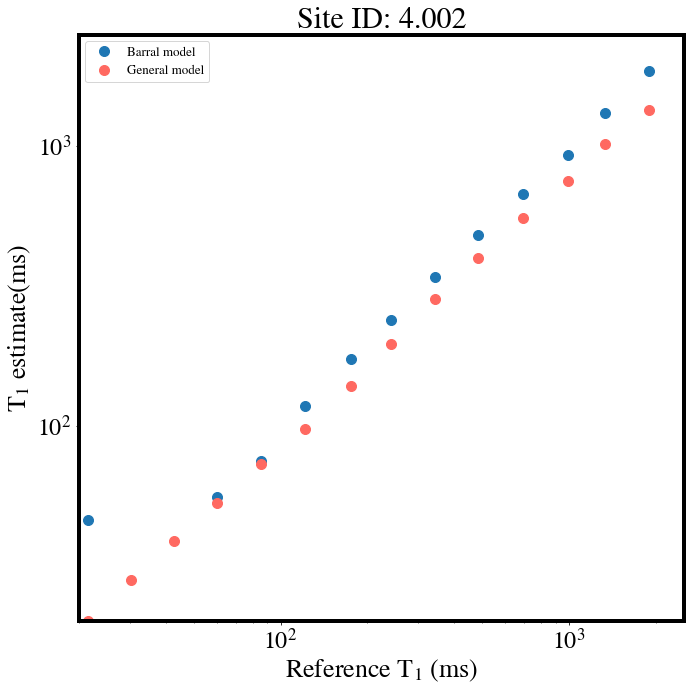

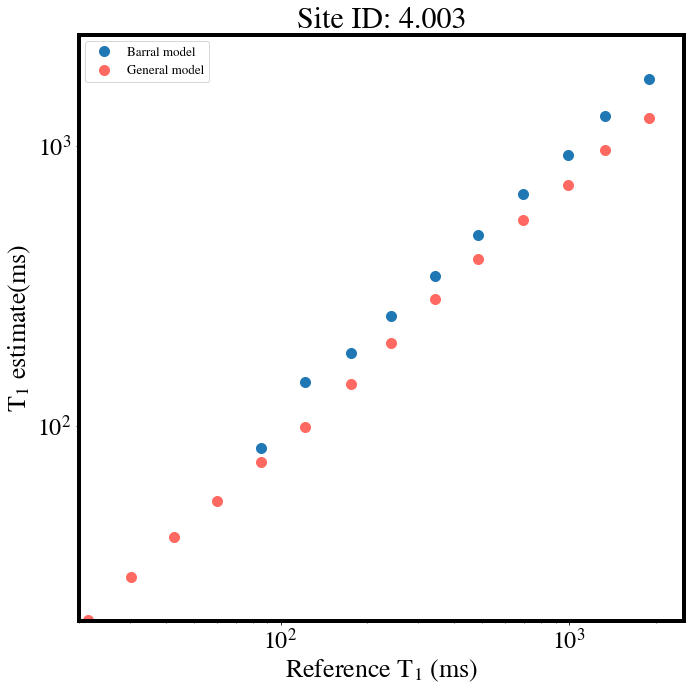

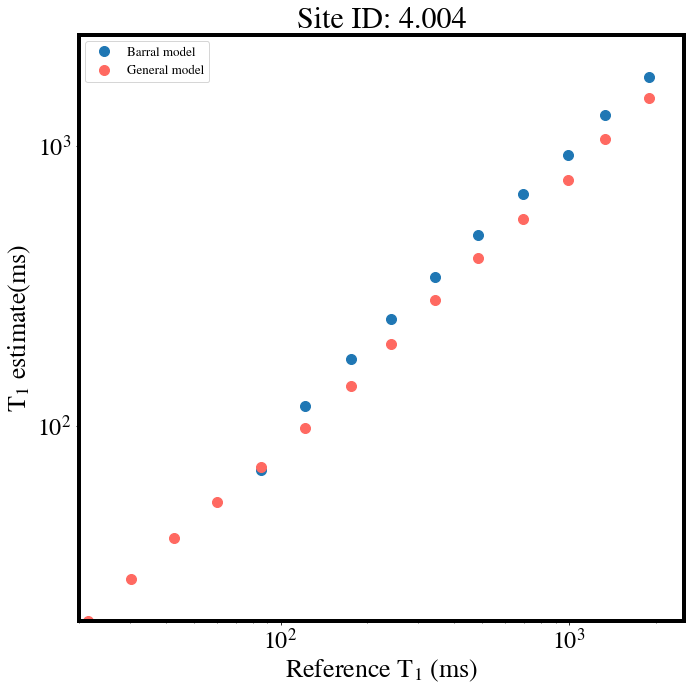

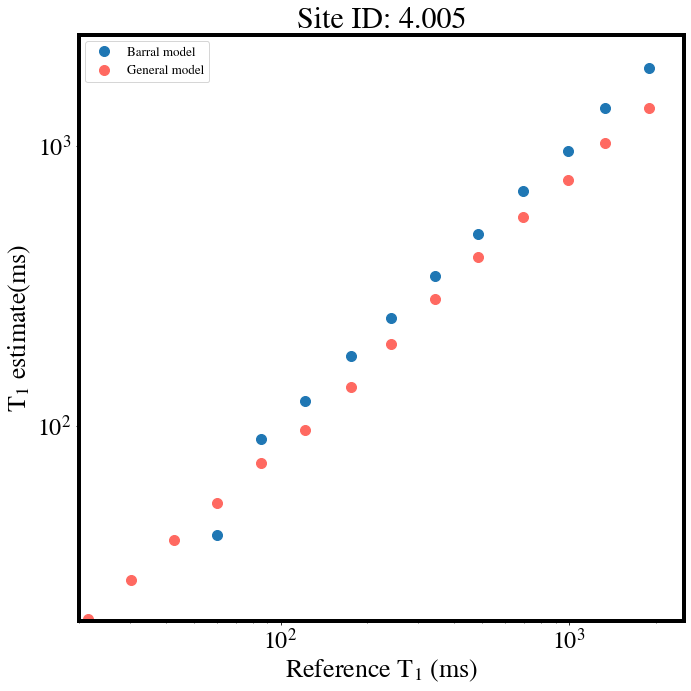

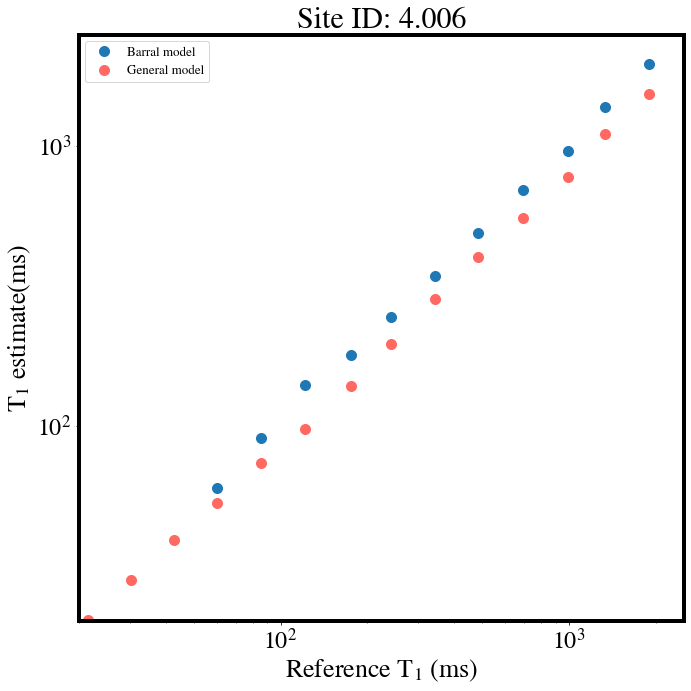

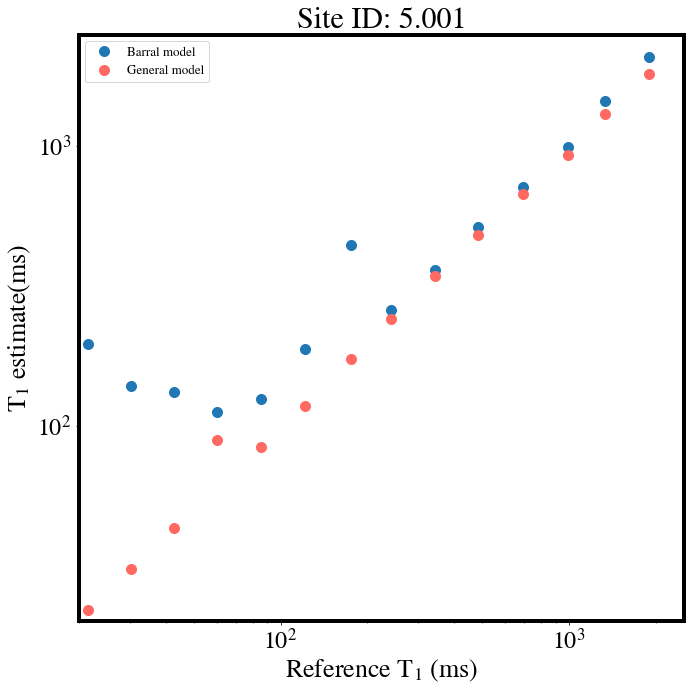

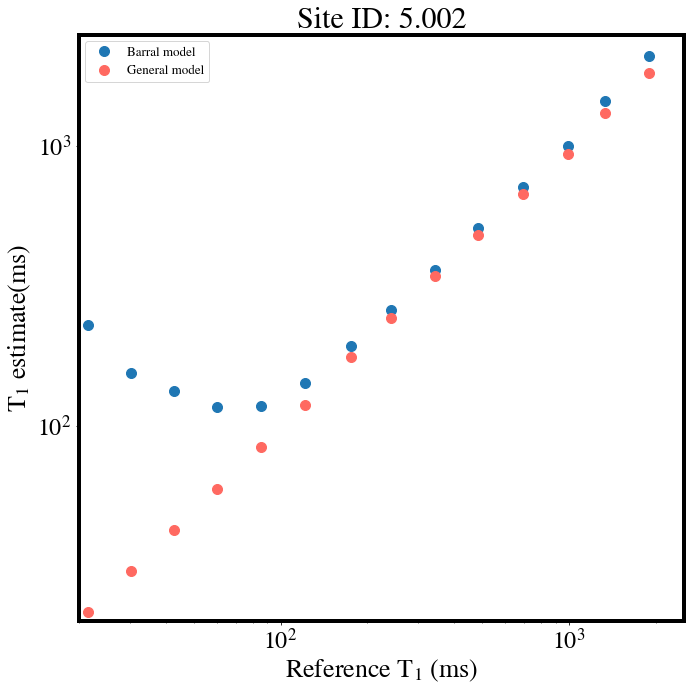

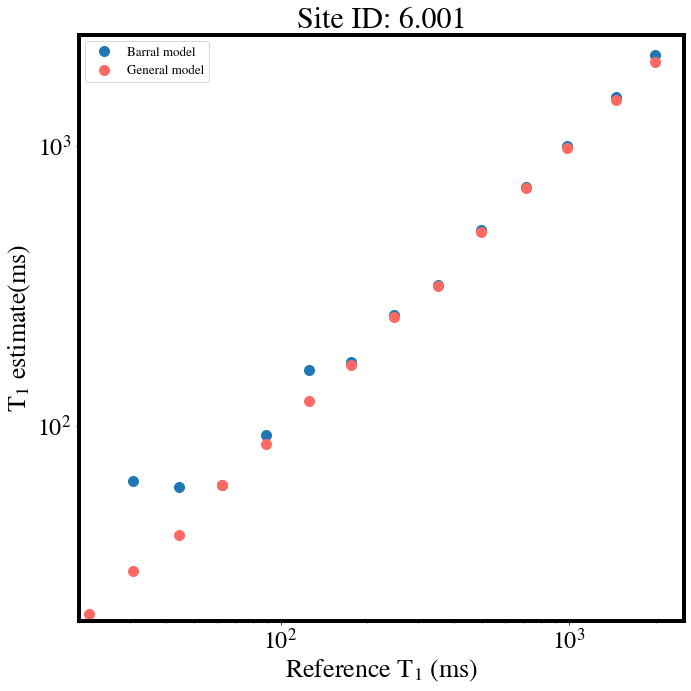

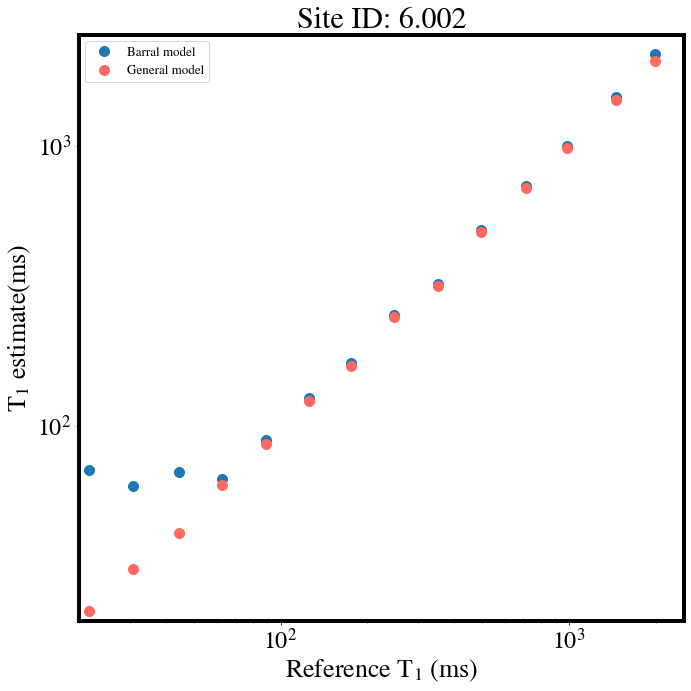

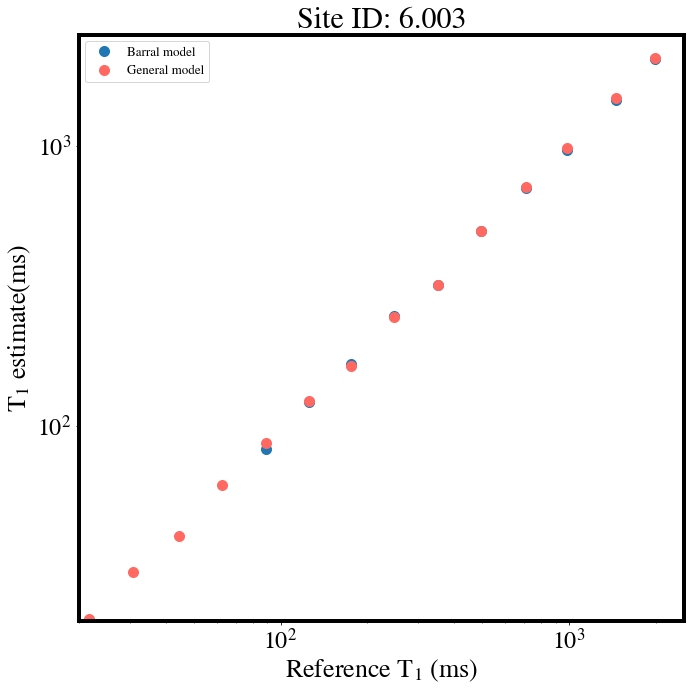

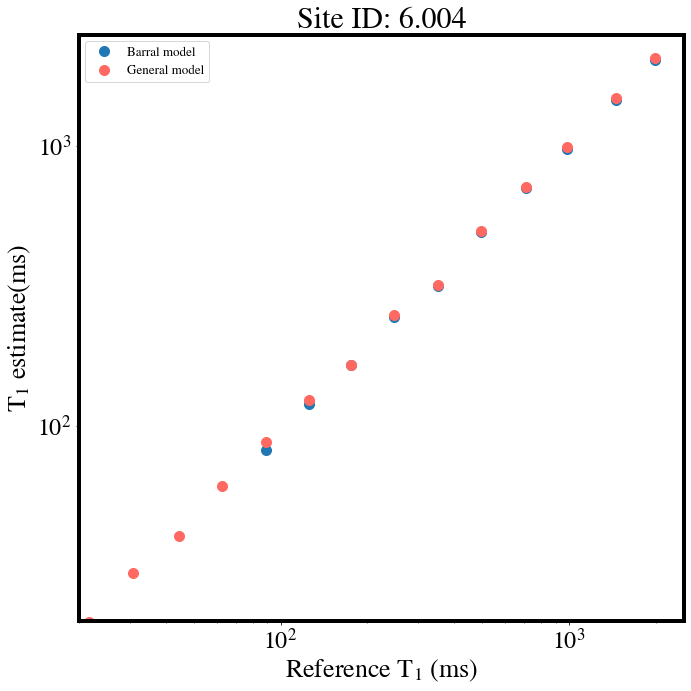

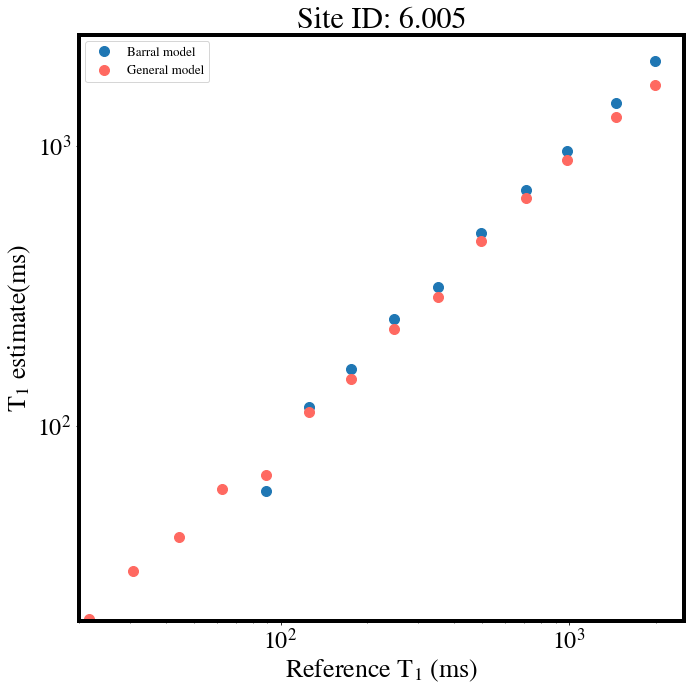

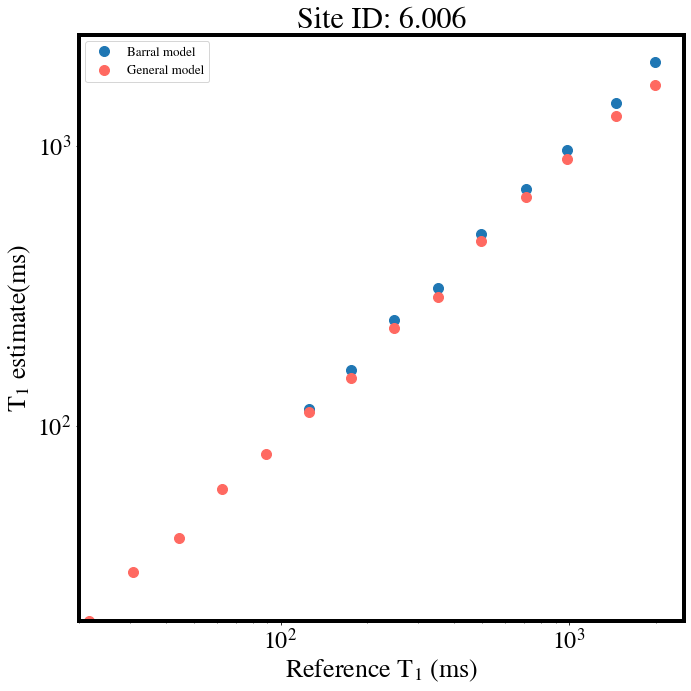

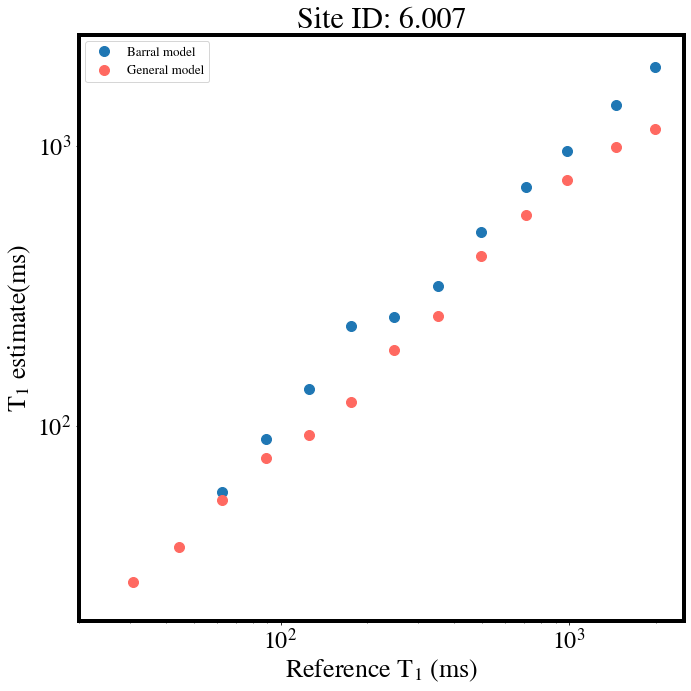

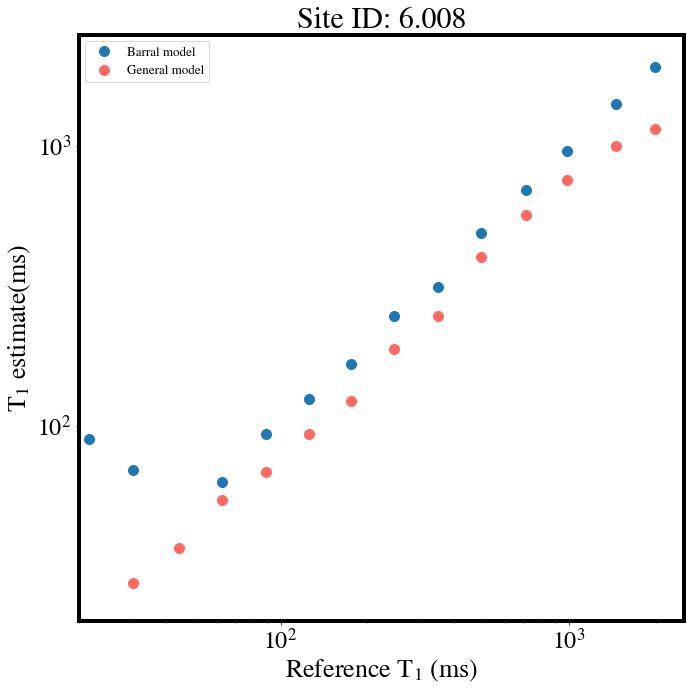

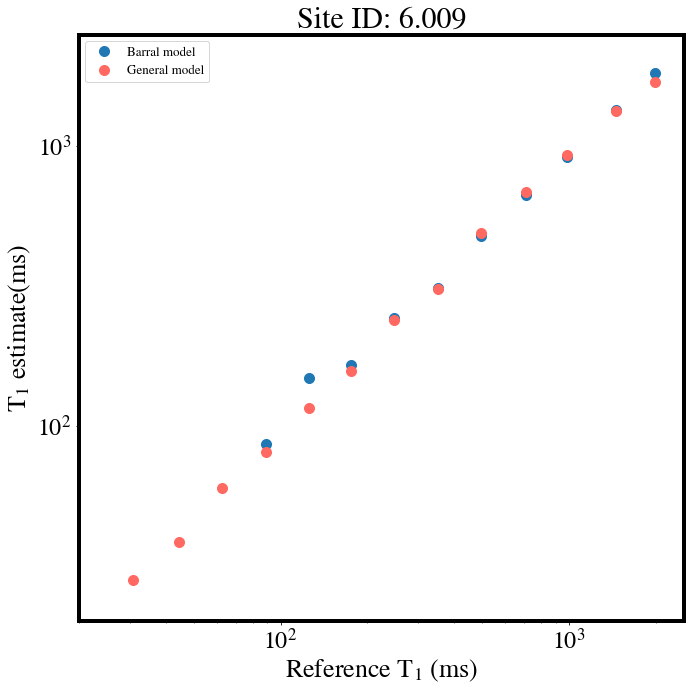

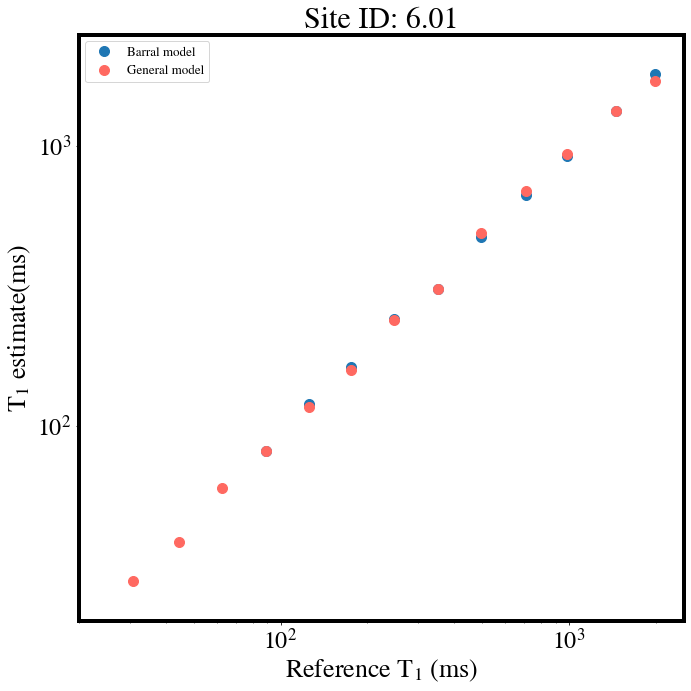

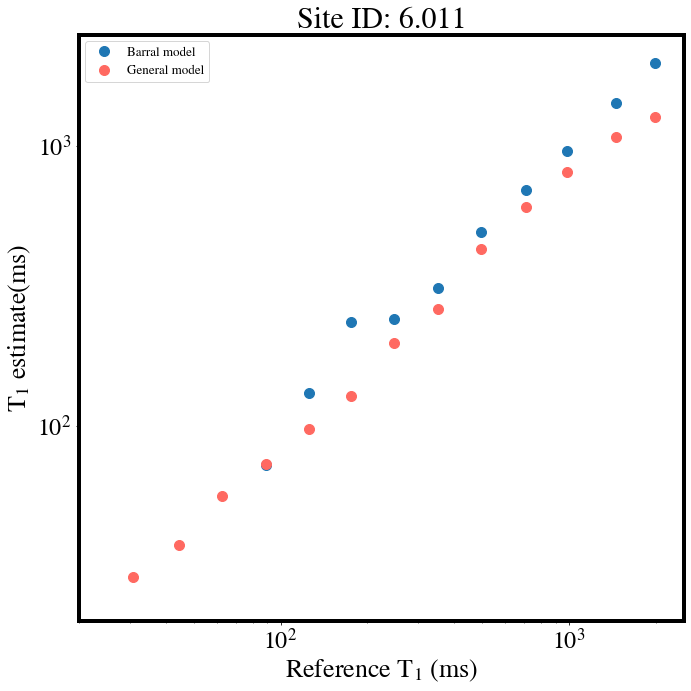

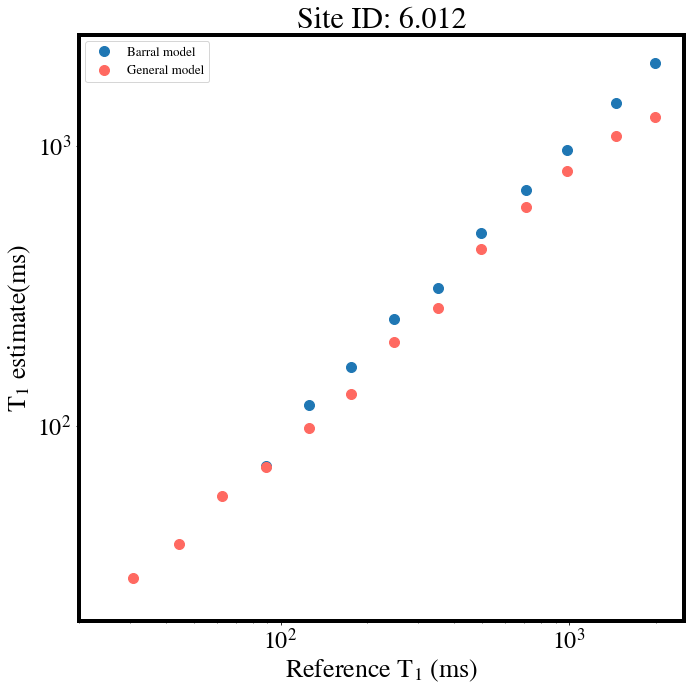

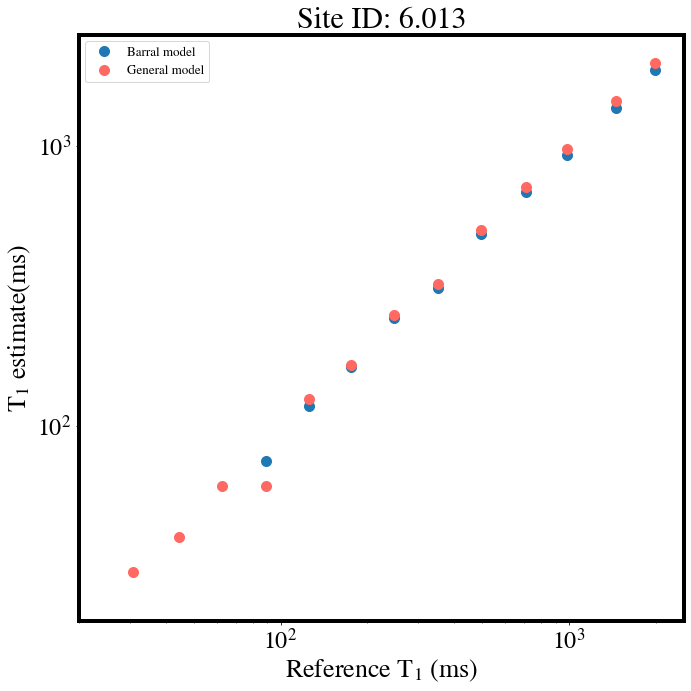

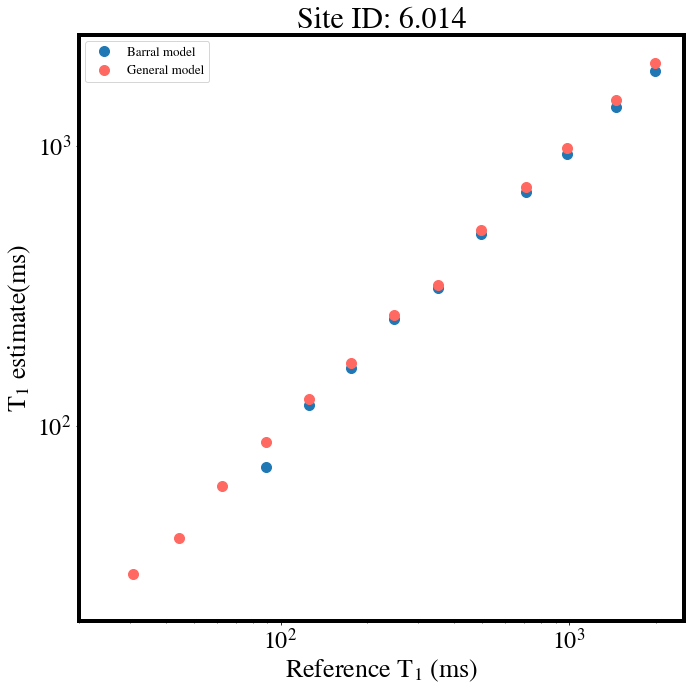

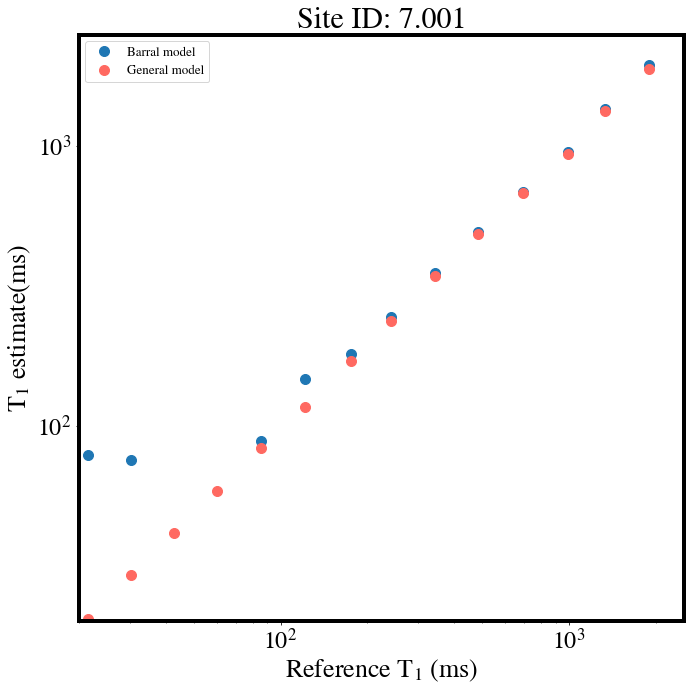

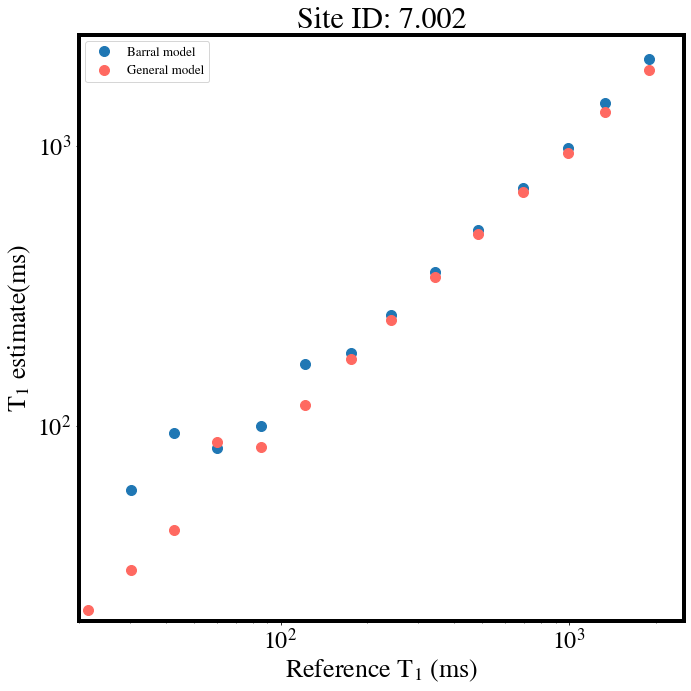

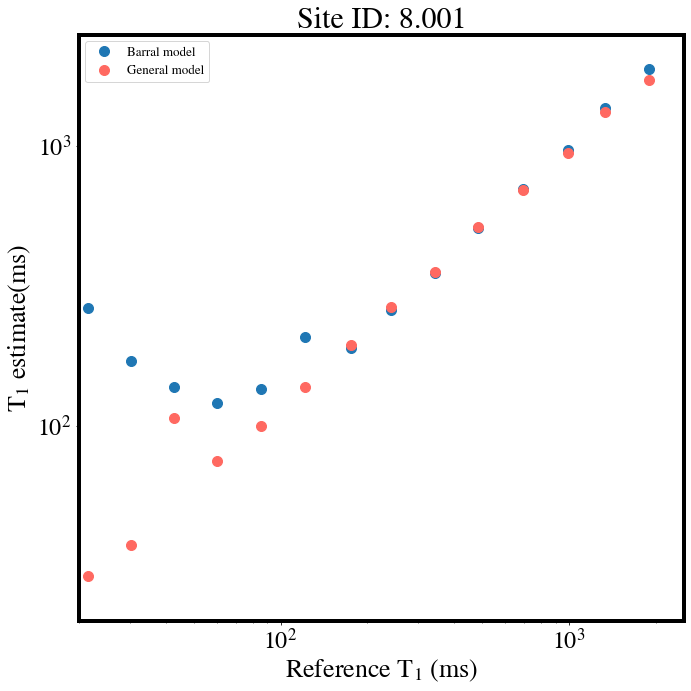

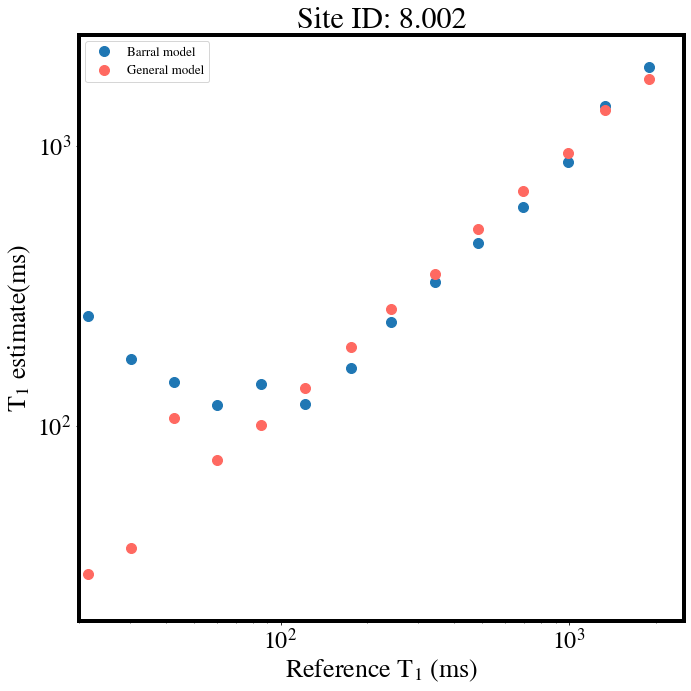

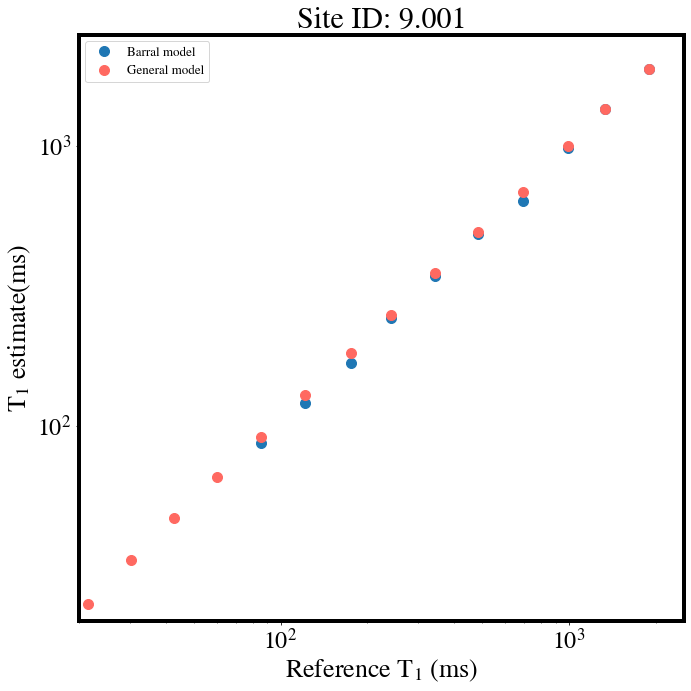

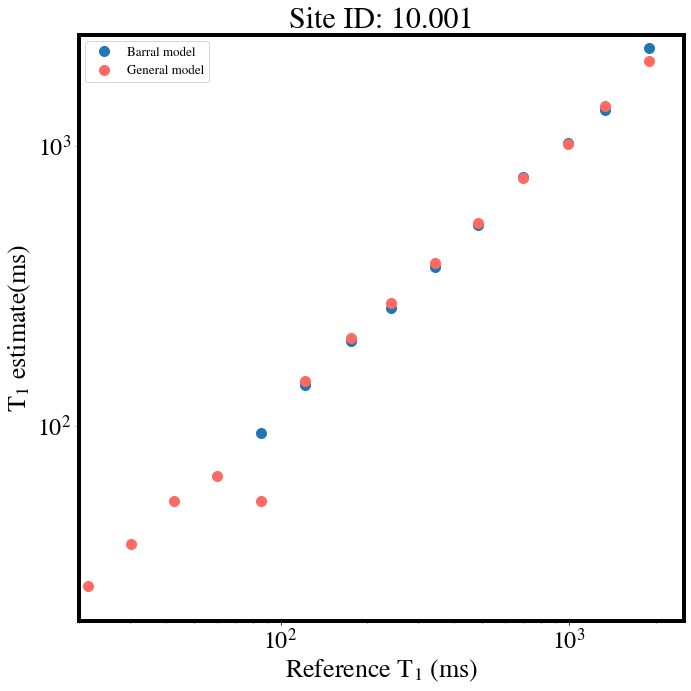

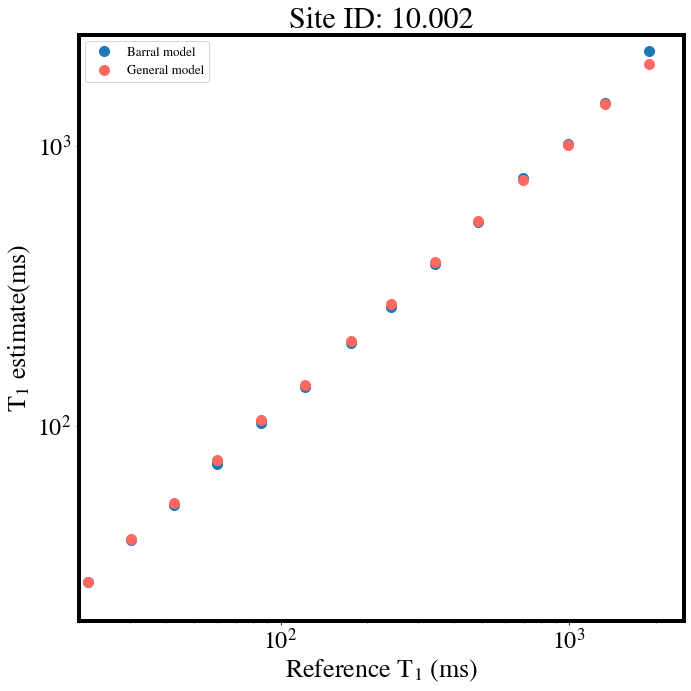

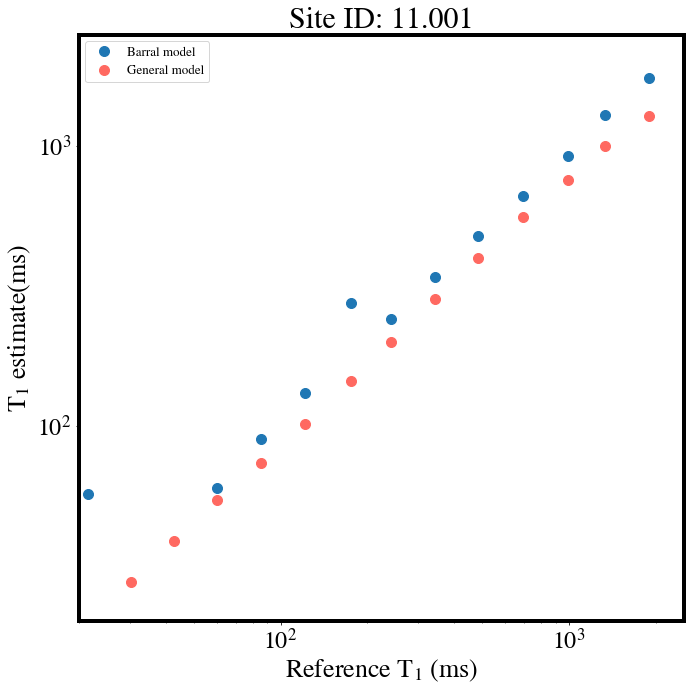

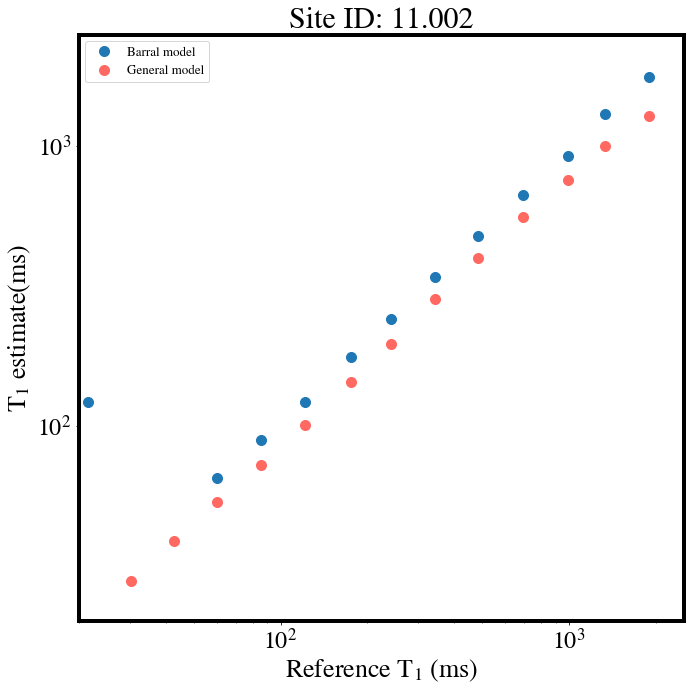

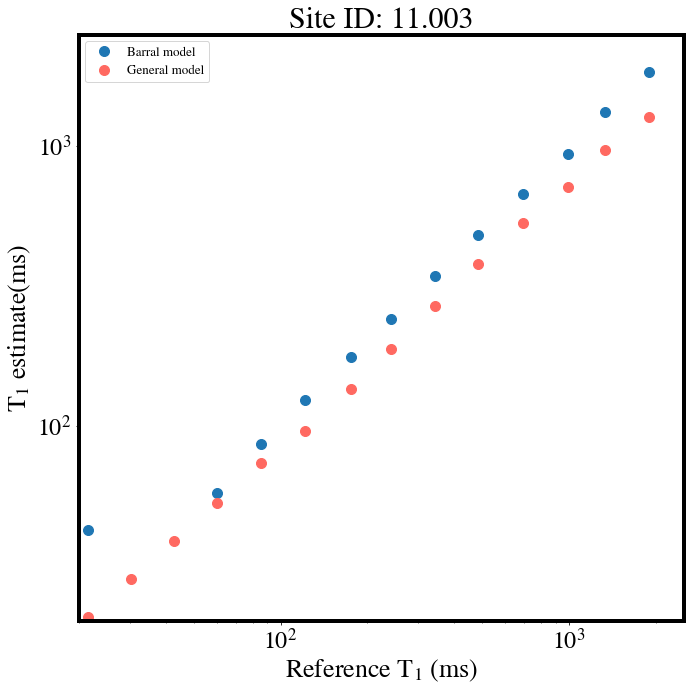

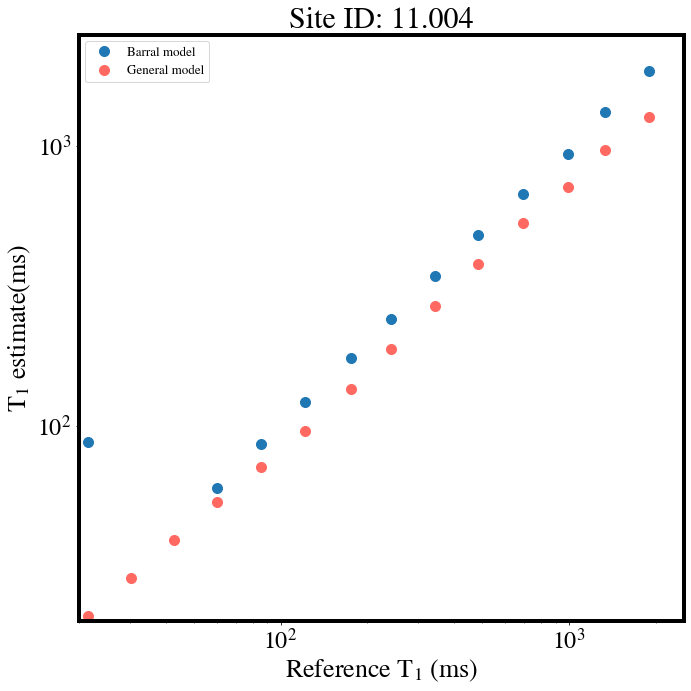

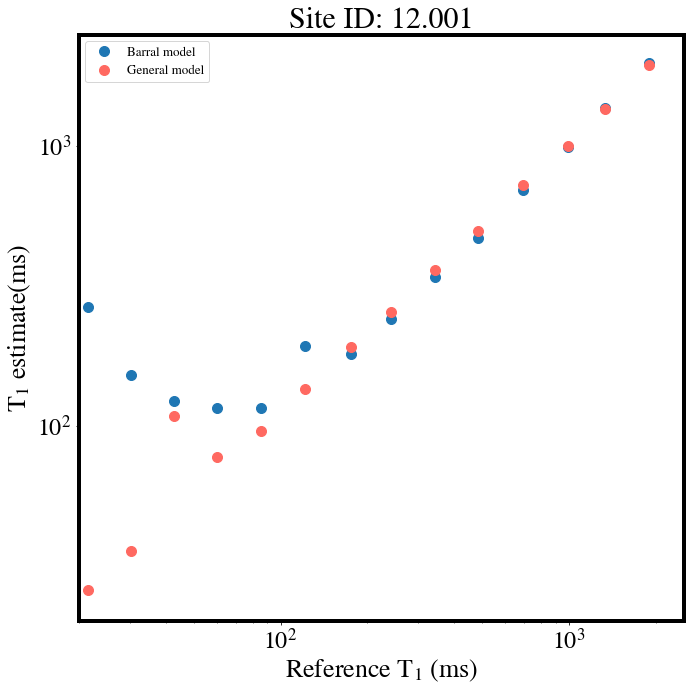

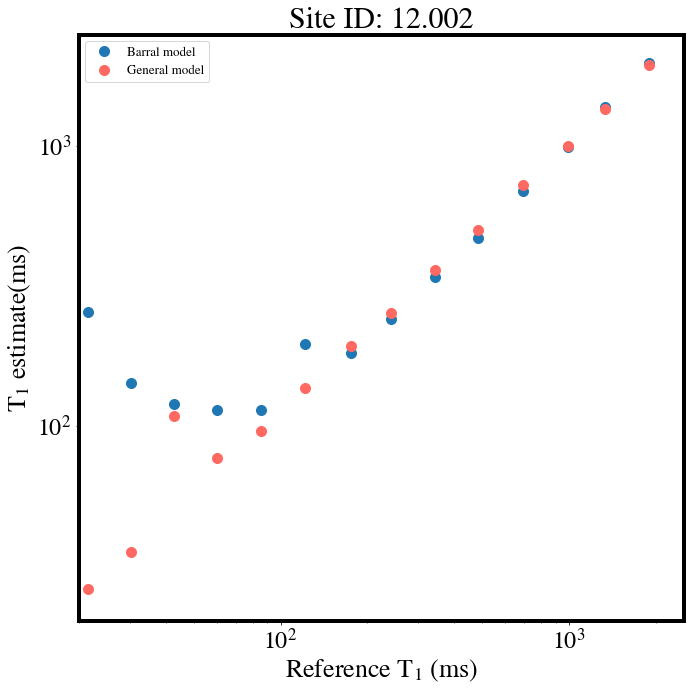

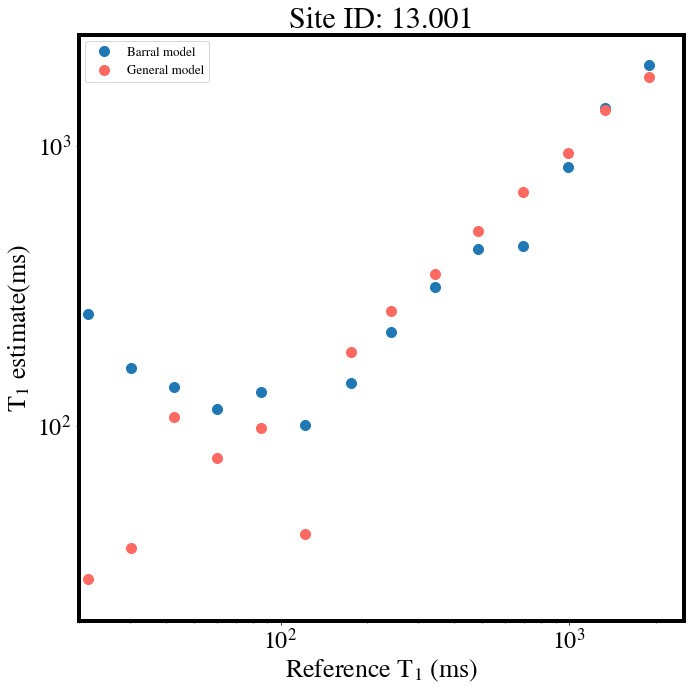

In [9]:
y_type = 'linear'
title = 'Log-log axes'



for ii in range(dims[0]):
    
    fig_id = plot_single_scatter(x=ref_values[ii,:],
                                 y1=dataset_estimate_barral[ii,:],
                                 y2=dataset_estimate_general[ii,:],
                                 y1_std=dataset_std_barral[ii,:],
                                 y2_std=dataset_std_general[ii,:],
                                 title='Site ID: '+ str(index_id[ii]),
                                 x_label='Reference T$_1$ (ms)',
                                 y_label="T$_1$ estimate(ms)",
                                 file_prefix=('log_' + str(index_id[ii])),
                                 folder_path=output_folder,
                                 fig_id=fig_id,
                                 y_type='log',
                                 labels=['Barral model', 'General model']
                                )

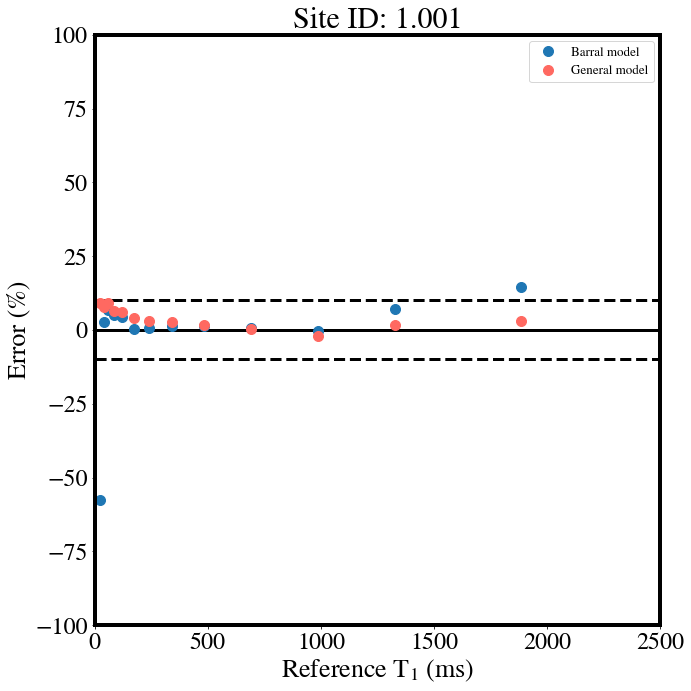

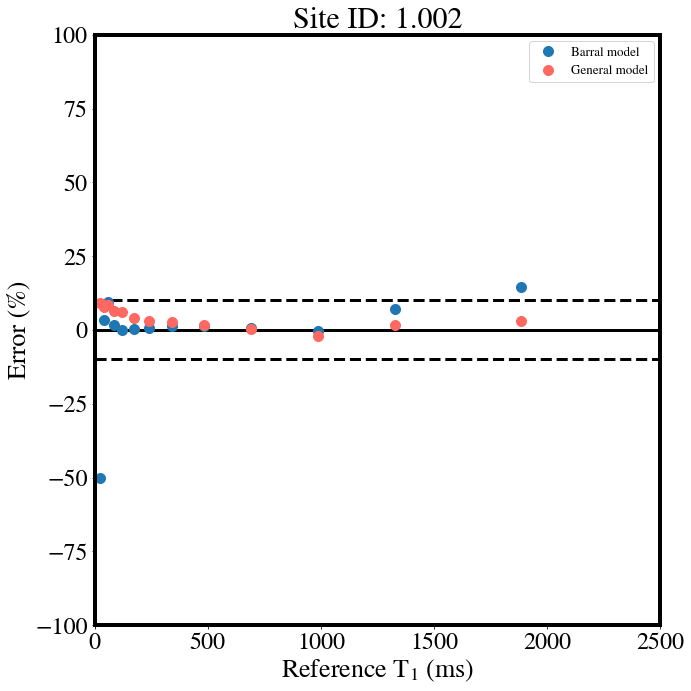

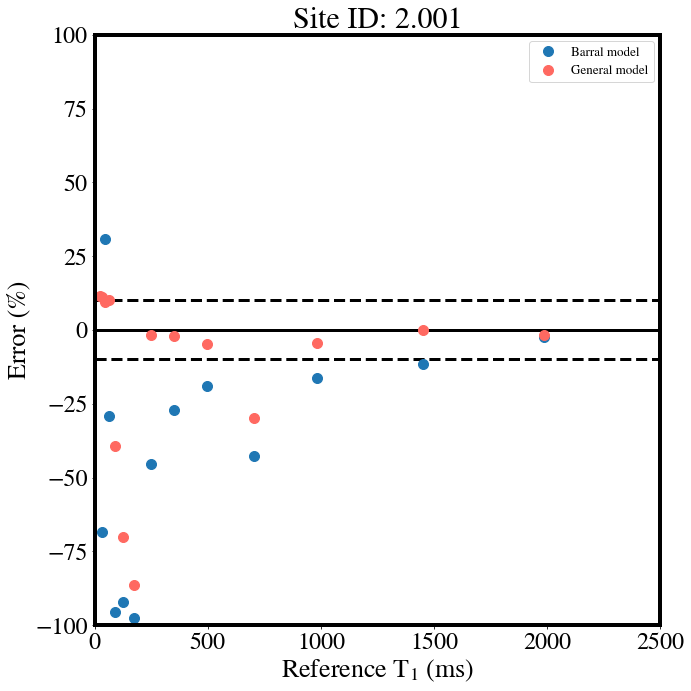

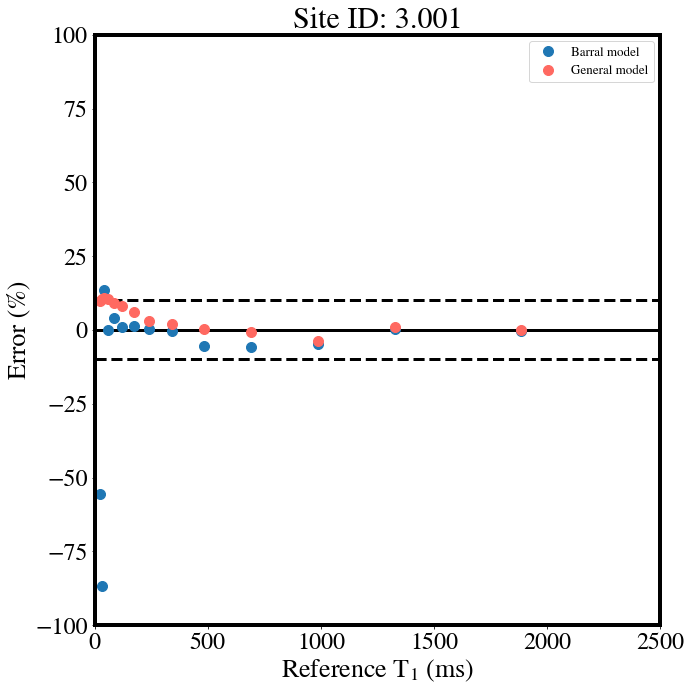

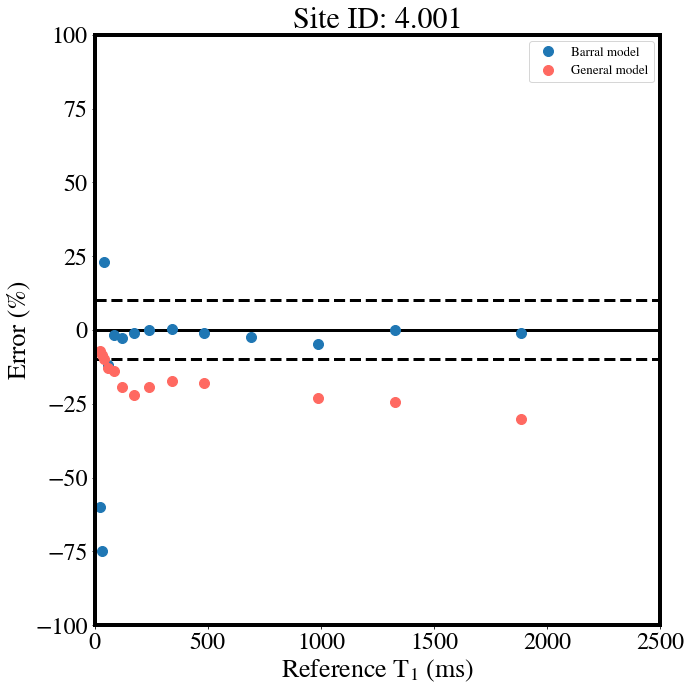

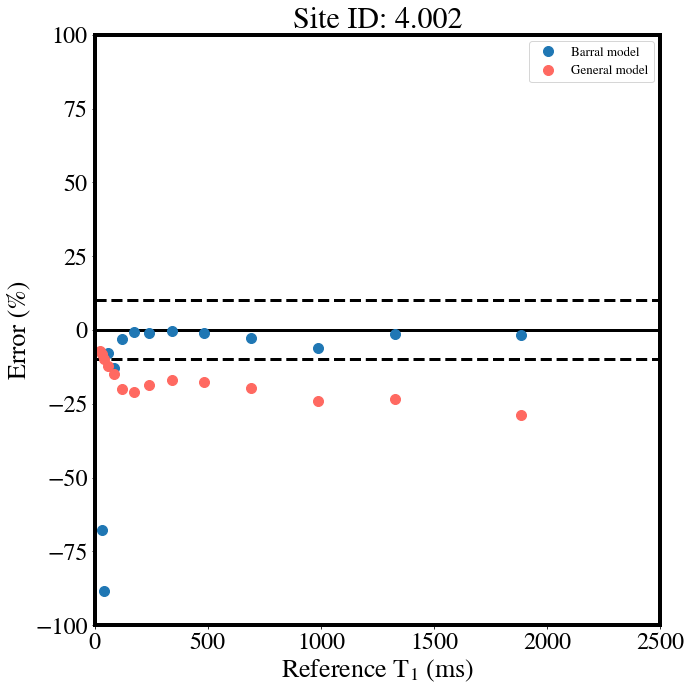

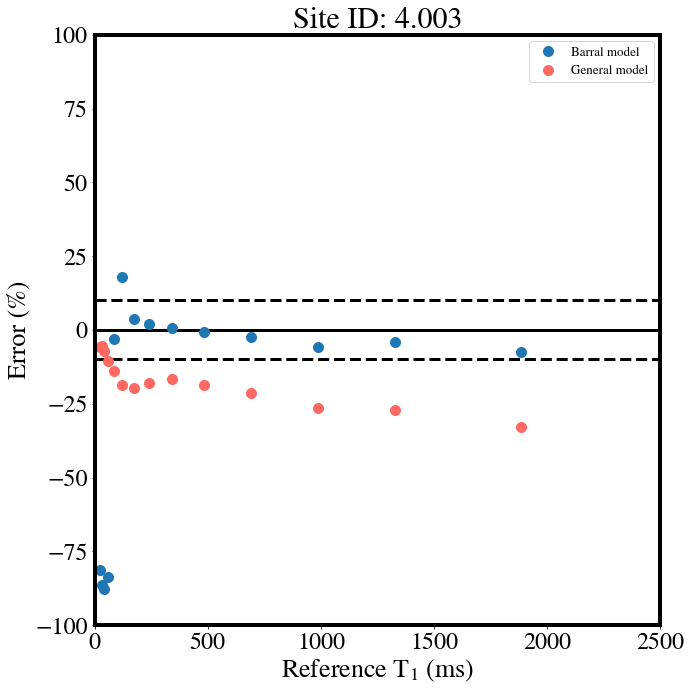

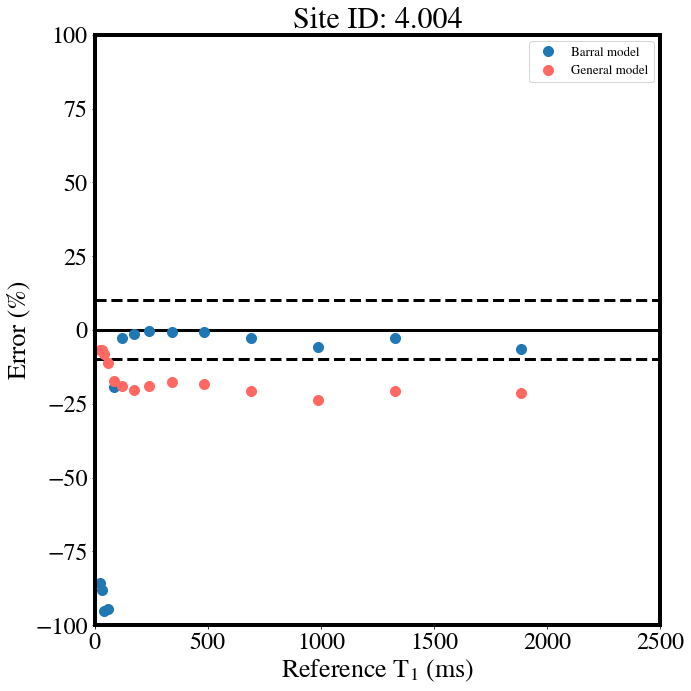

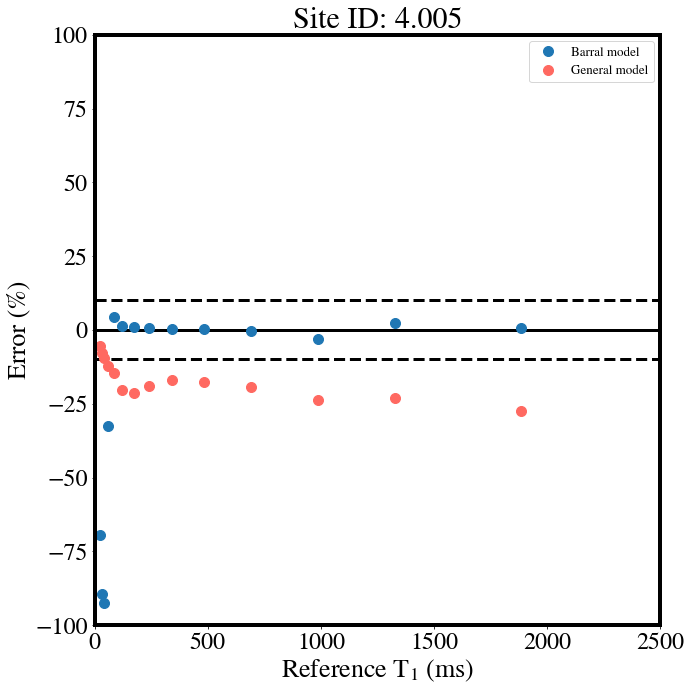

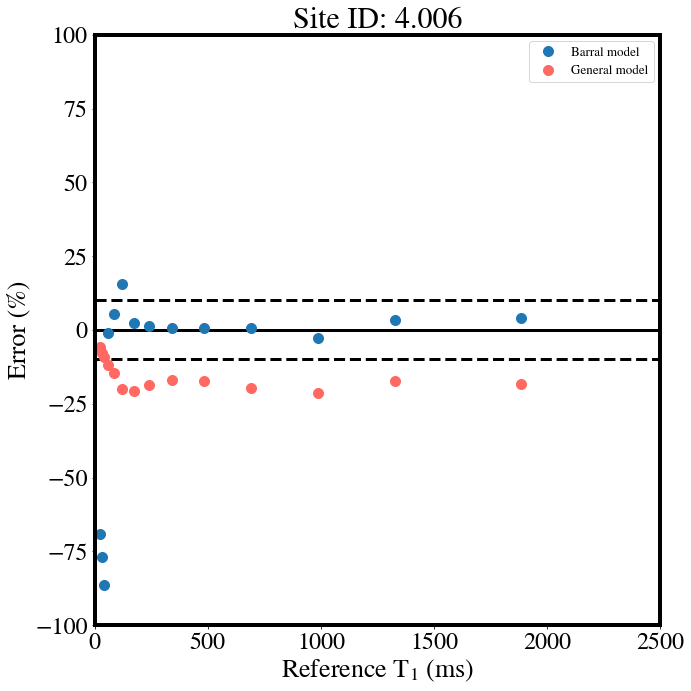

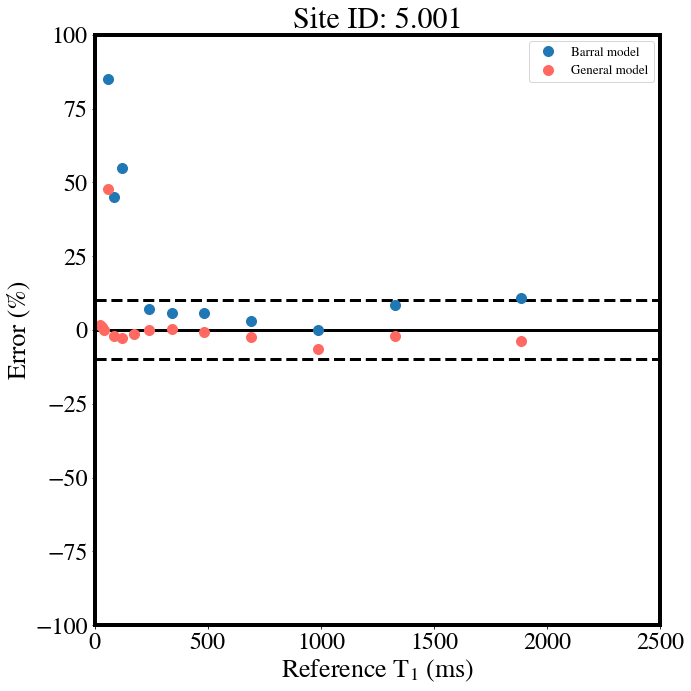

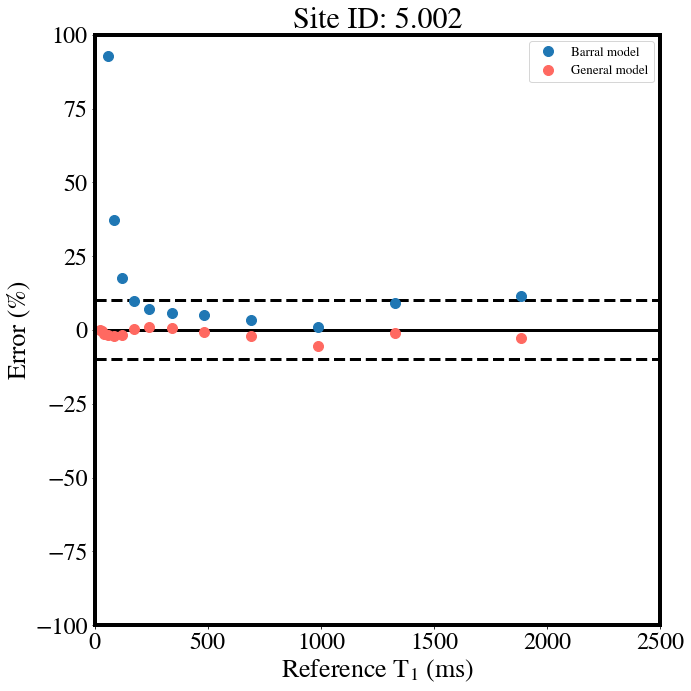

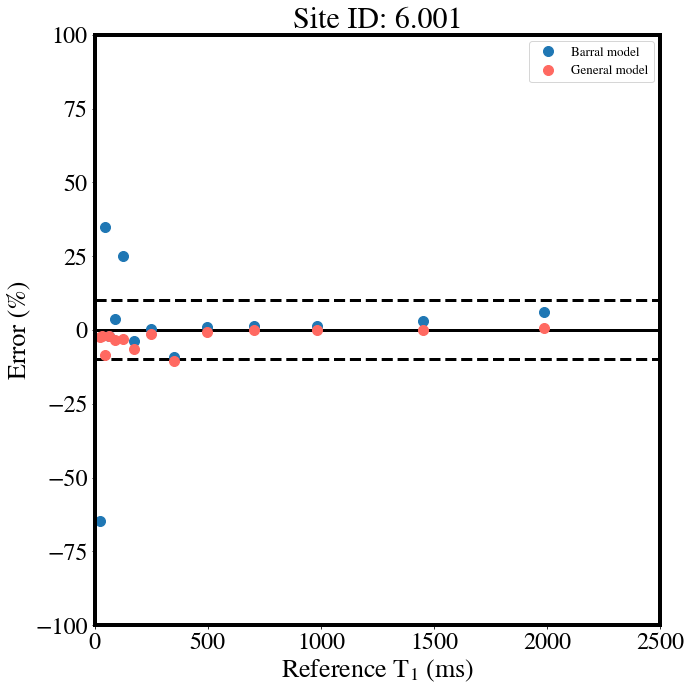

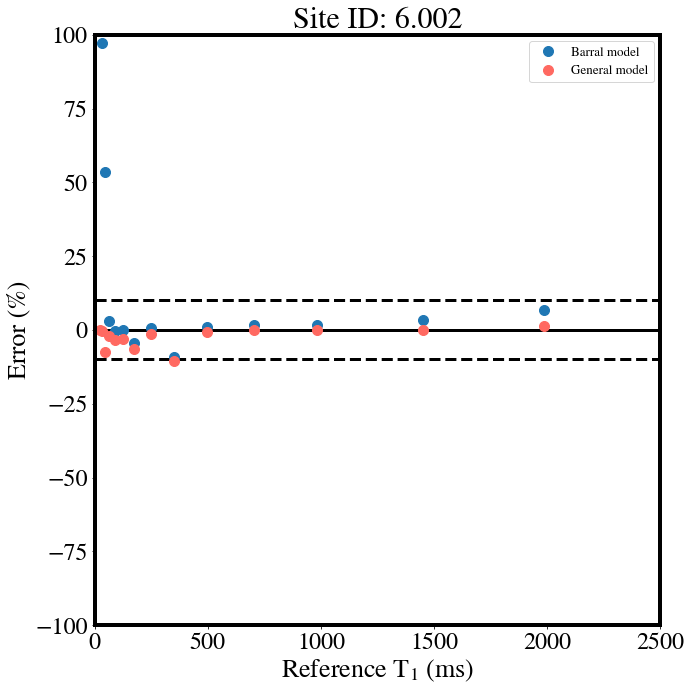

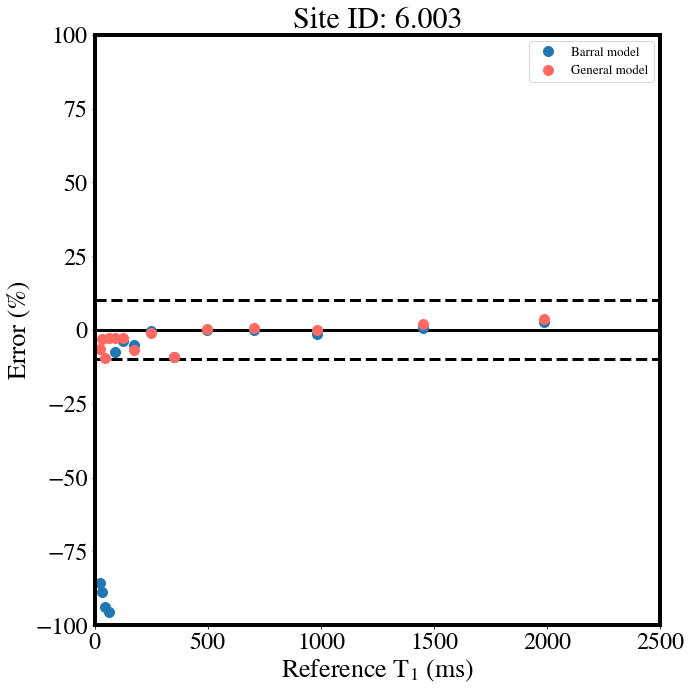

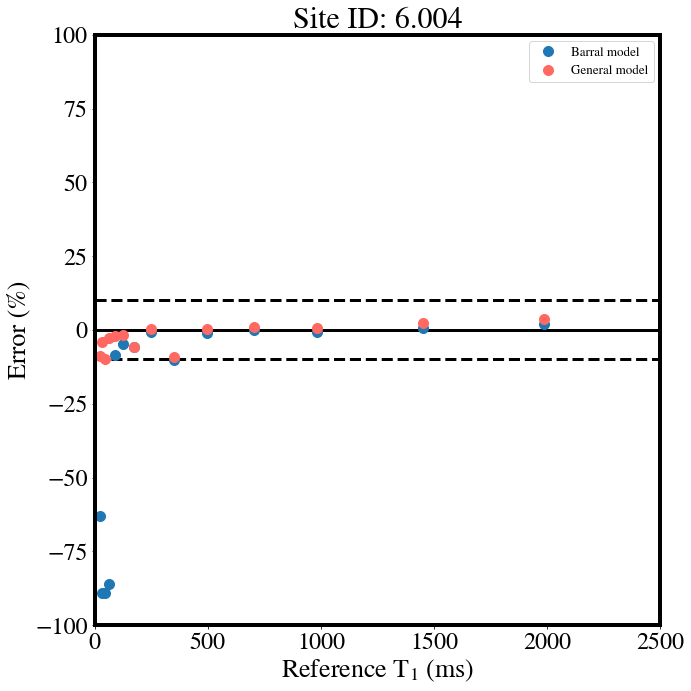

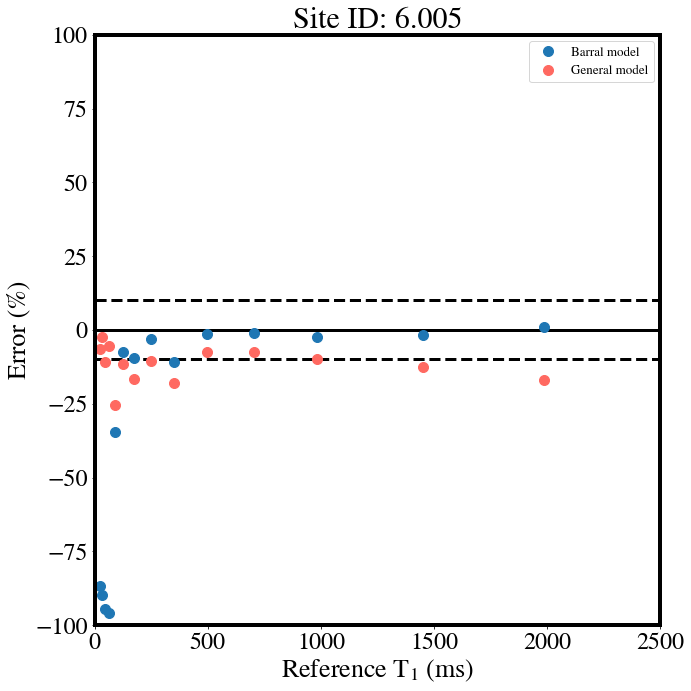

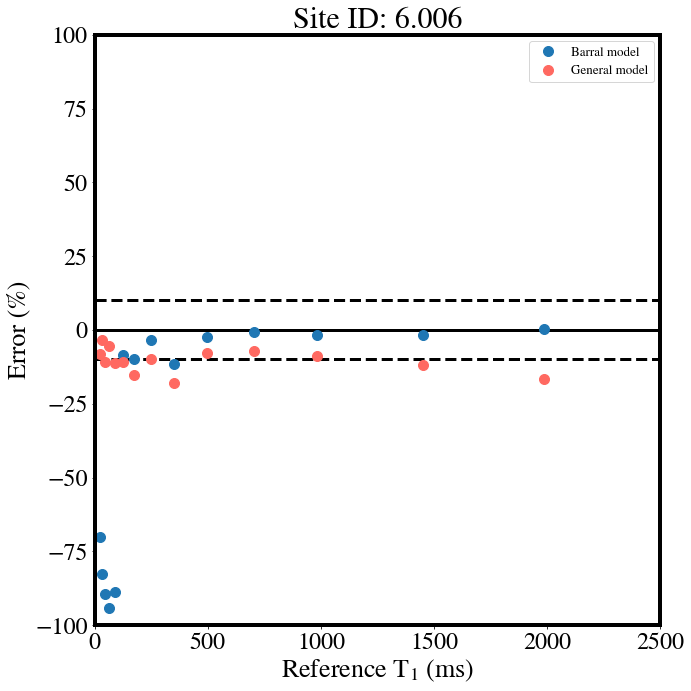

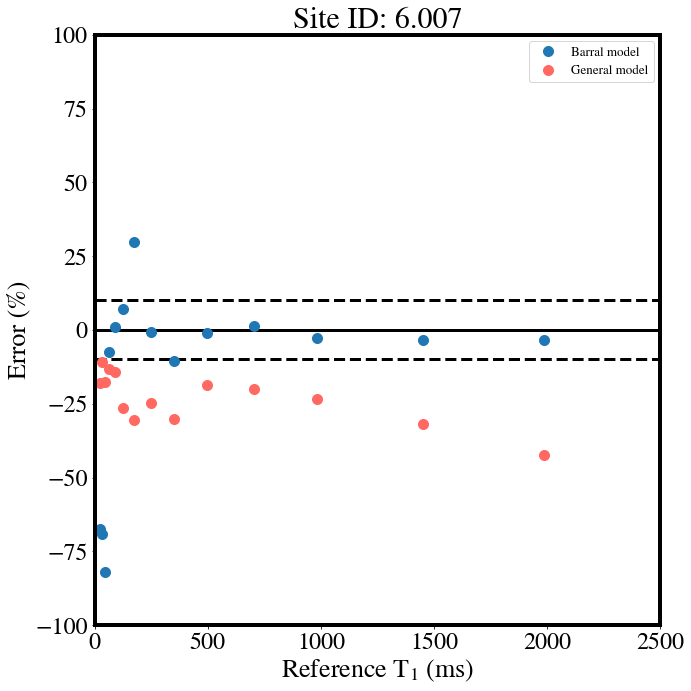

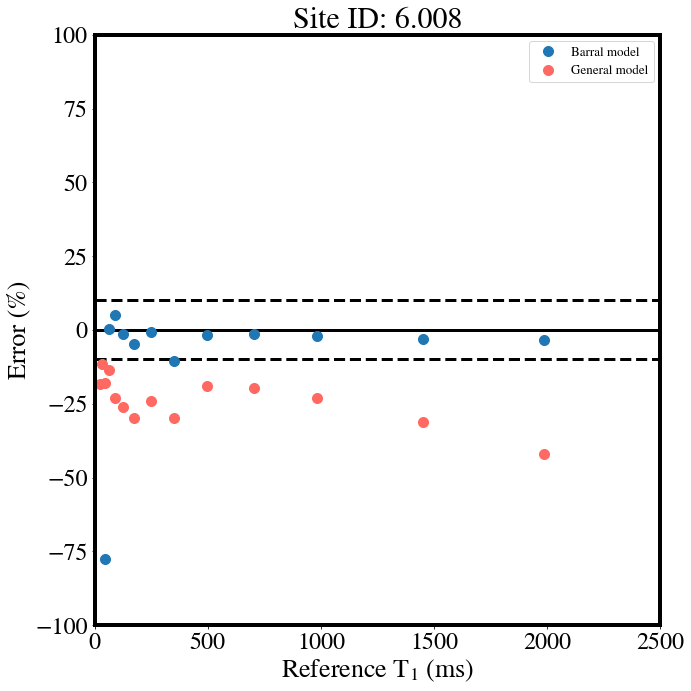

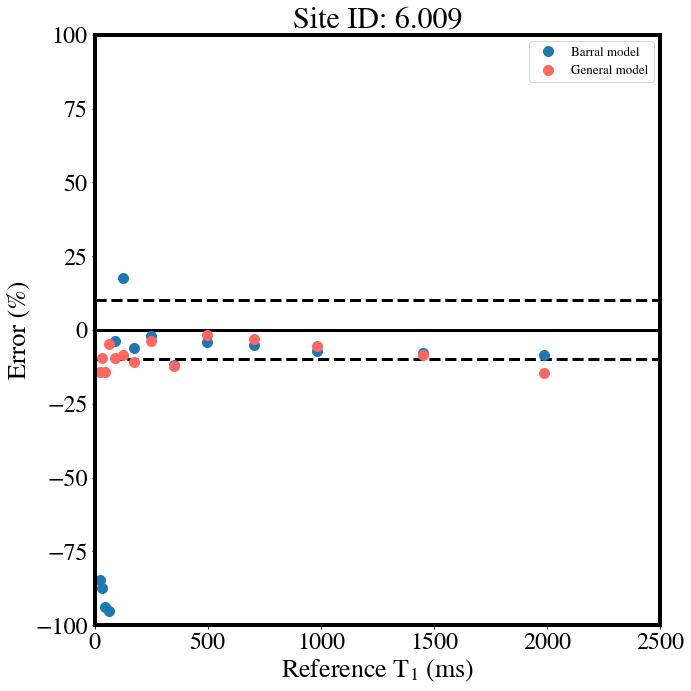

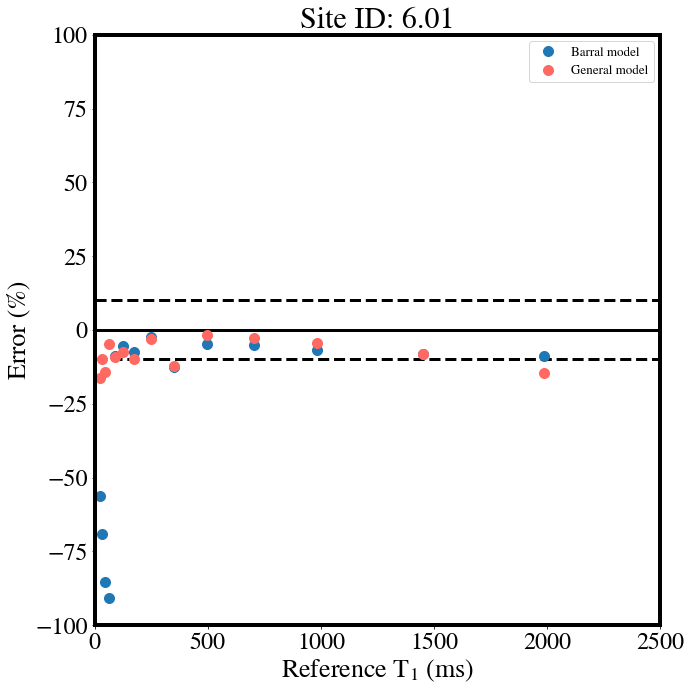

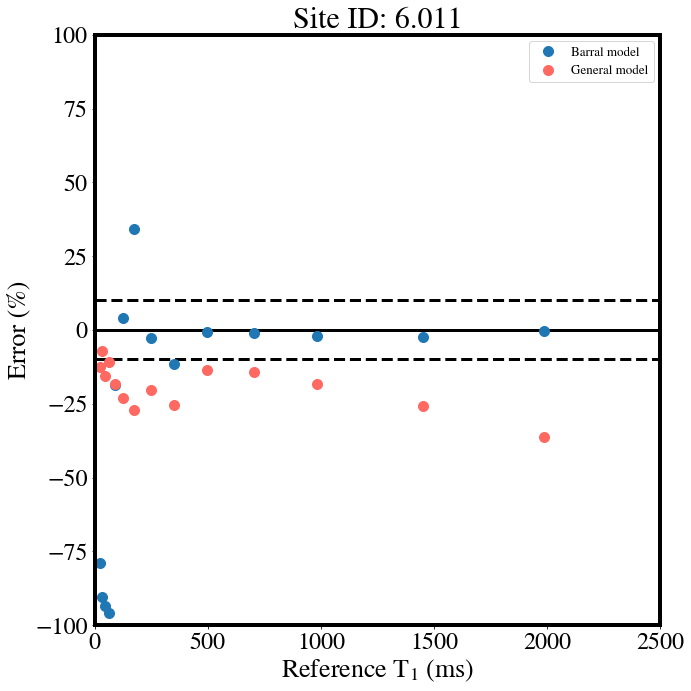

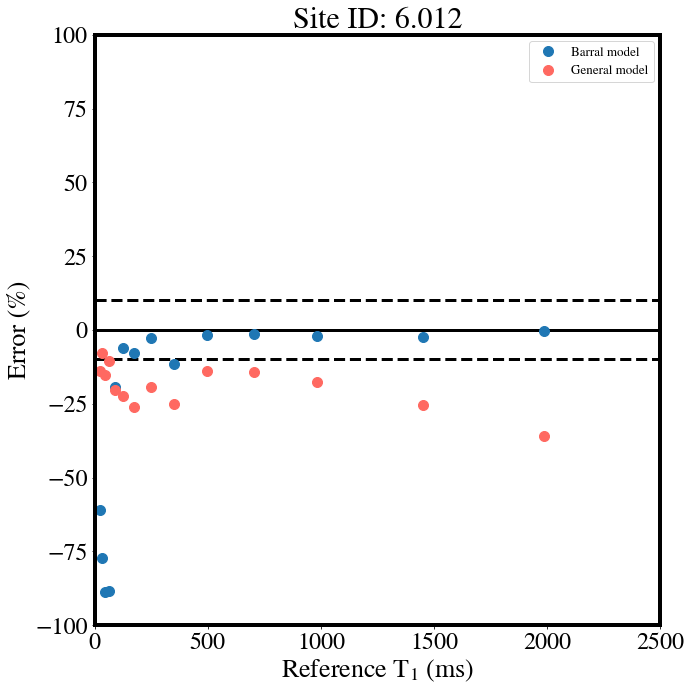

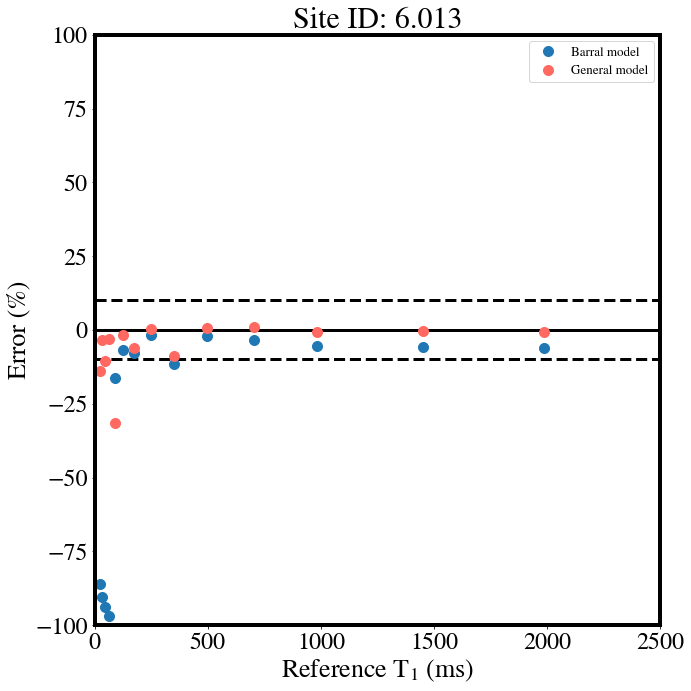

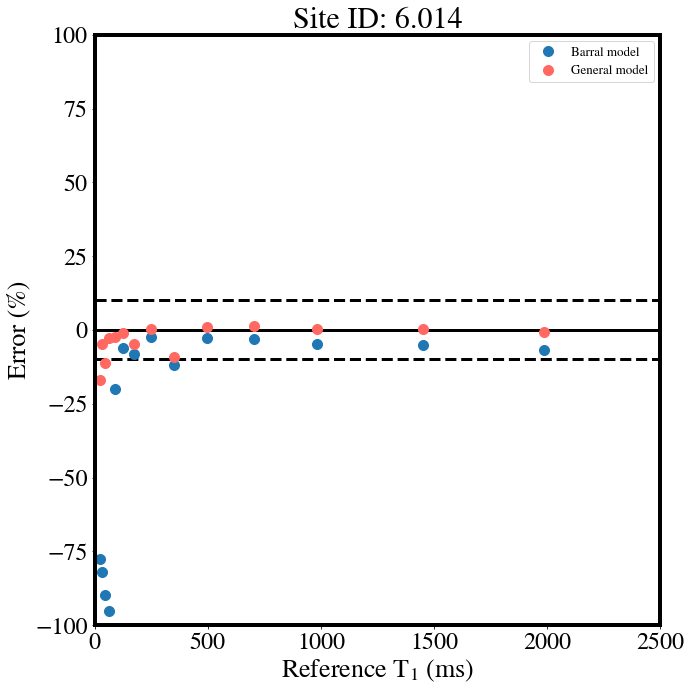

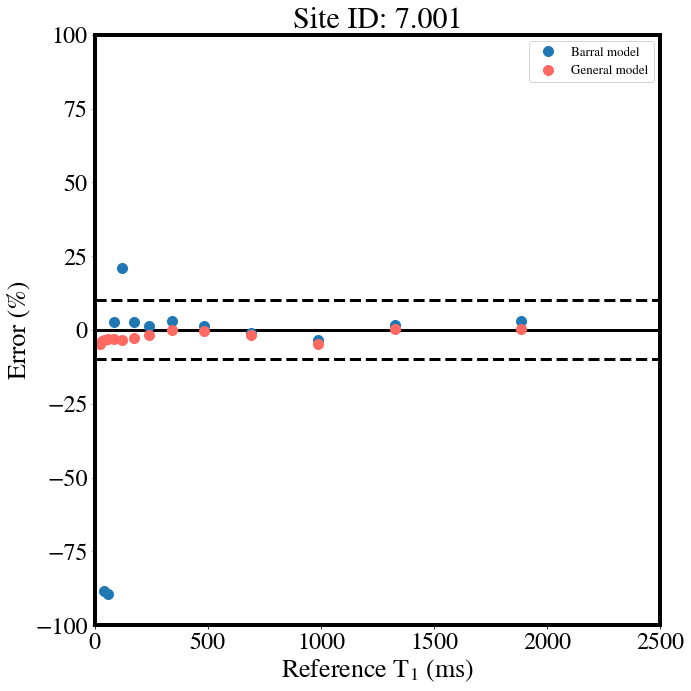

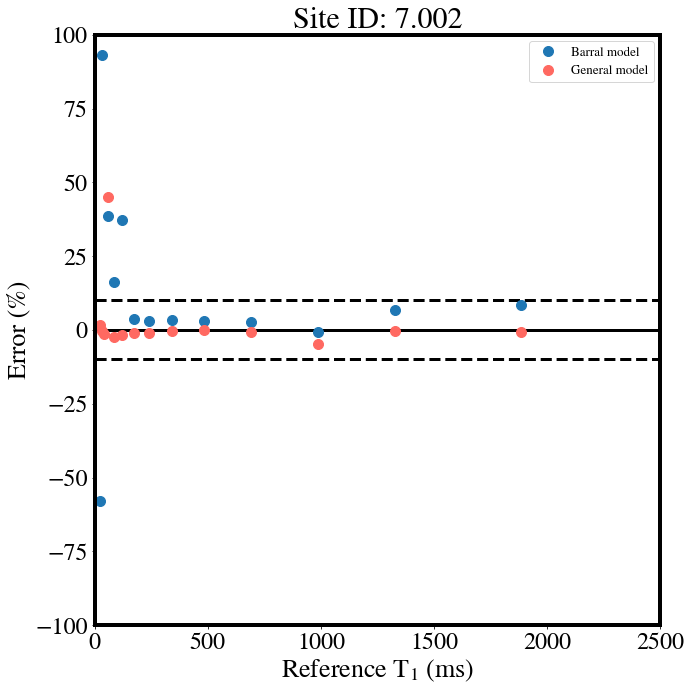

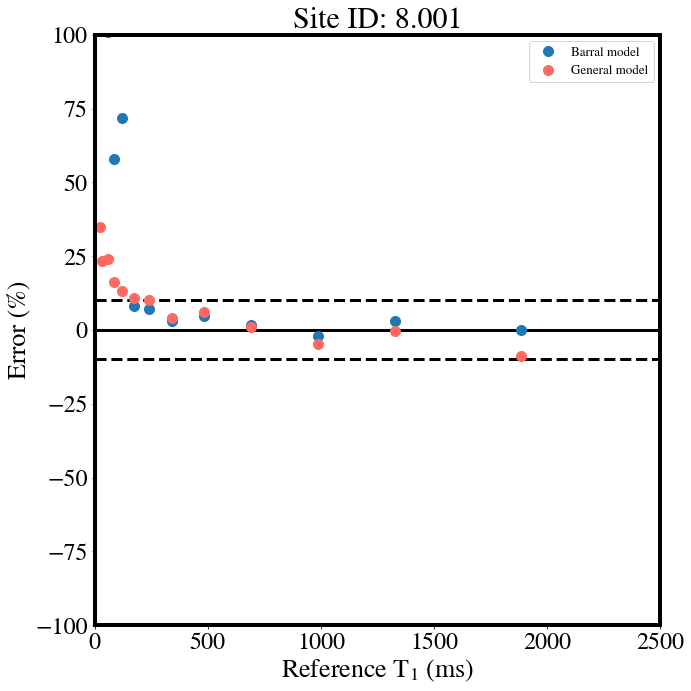

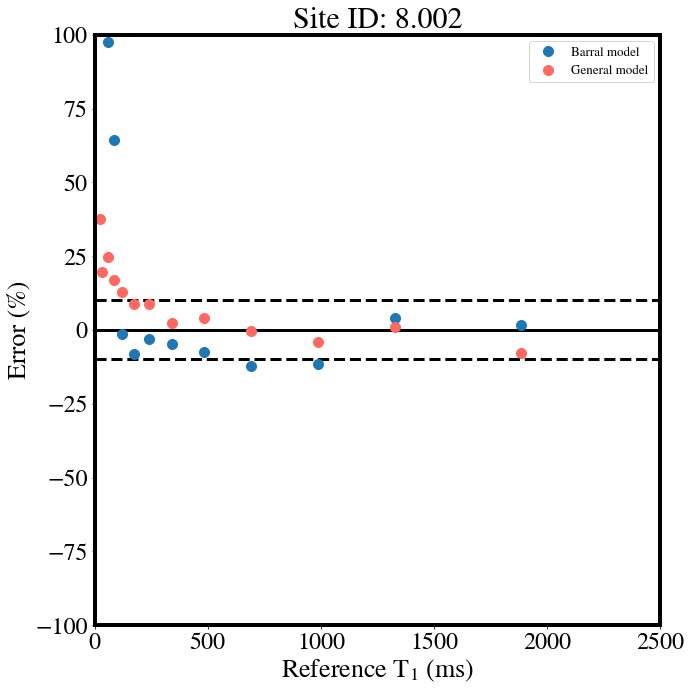

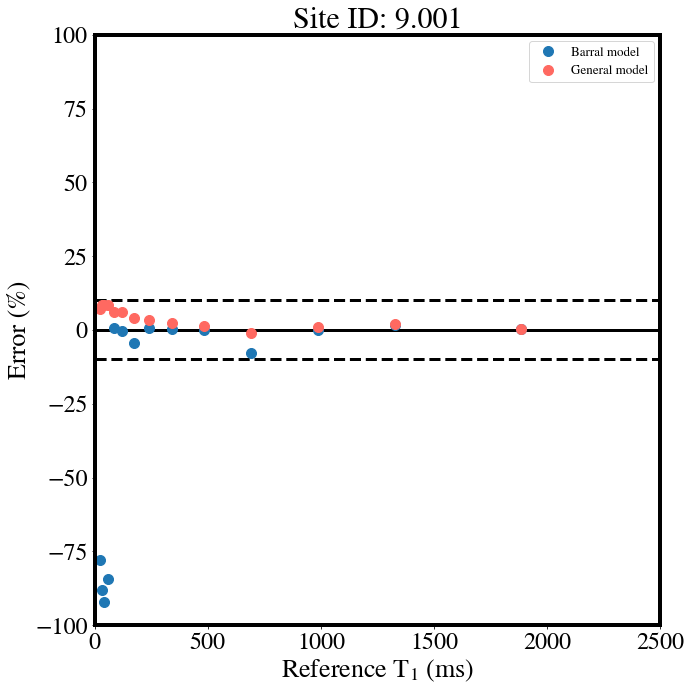

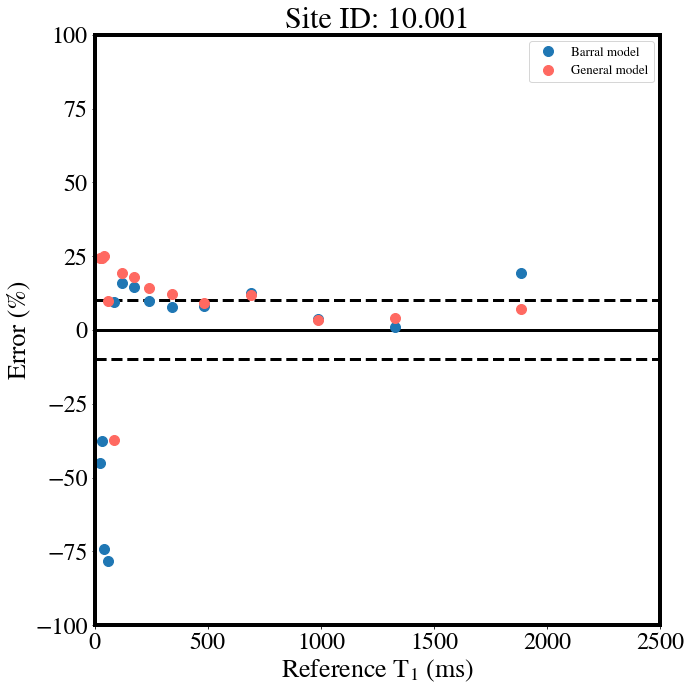

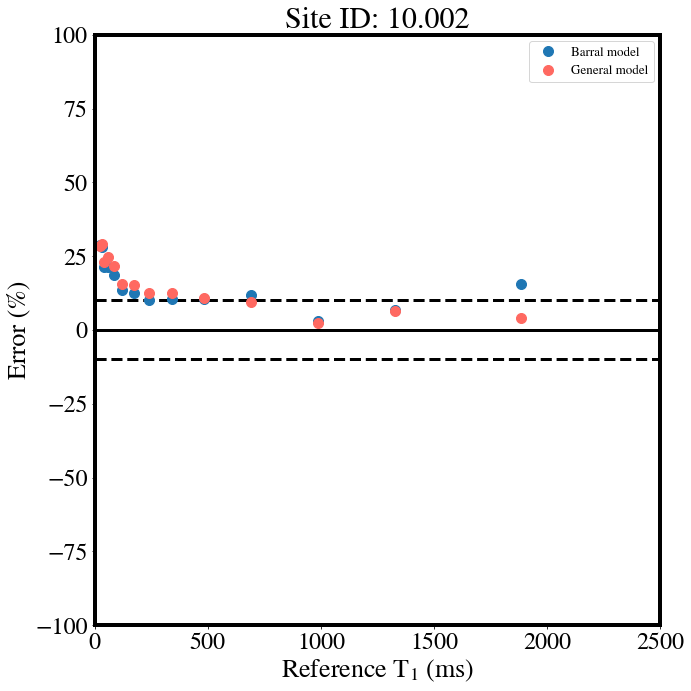

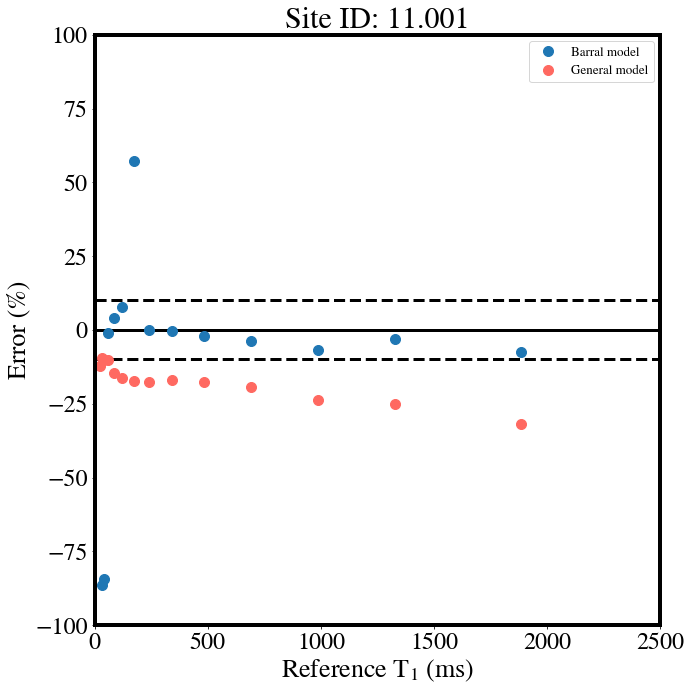

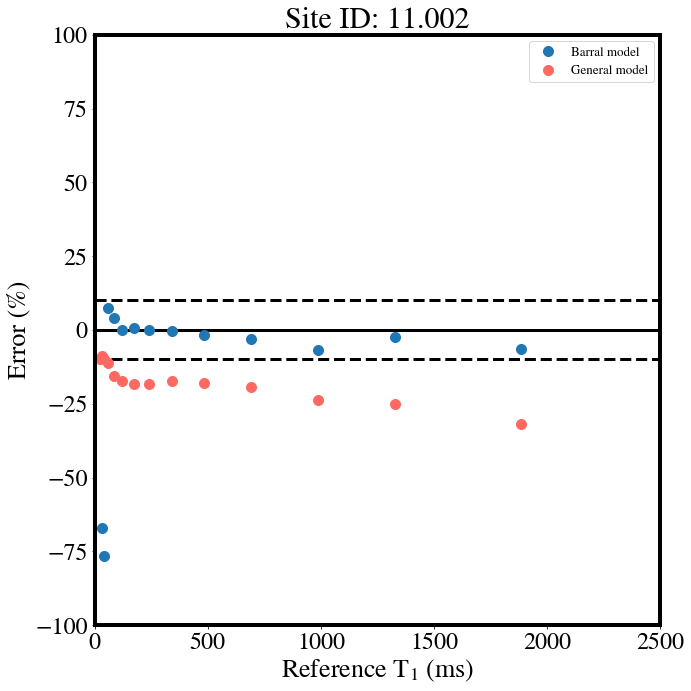

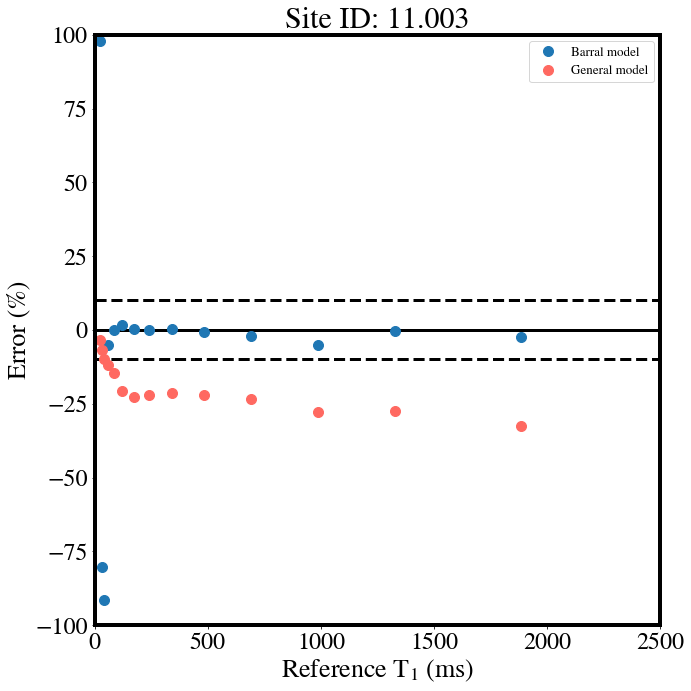

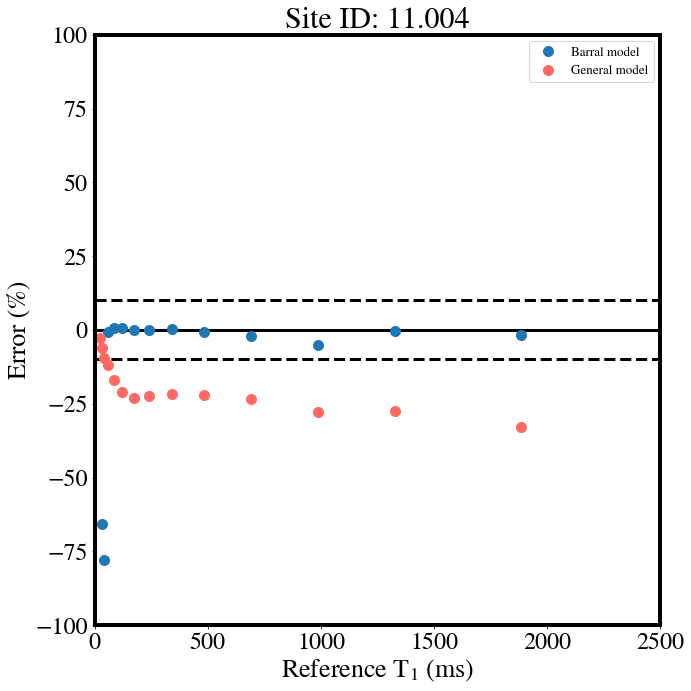

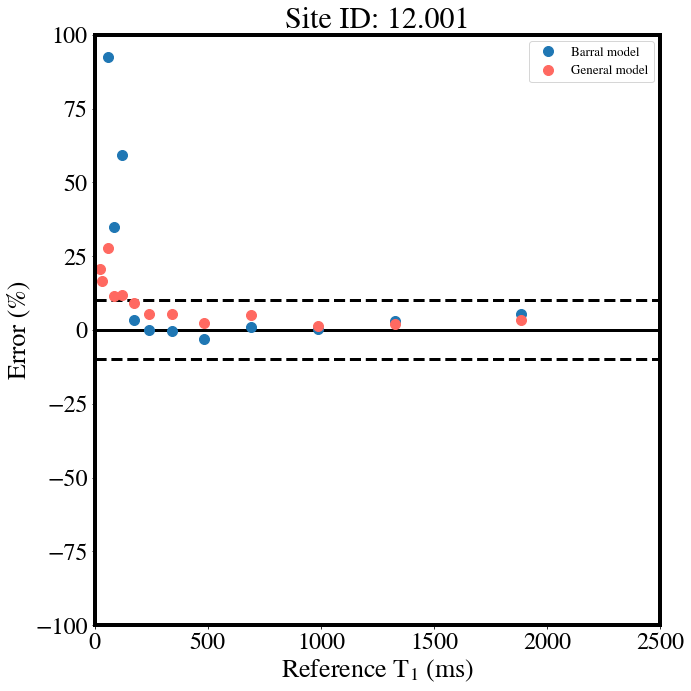

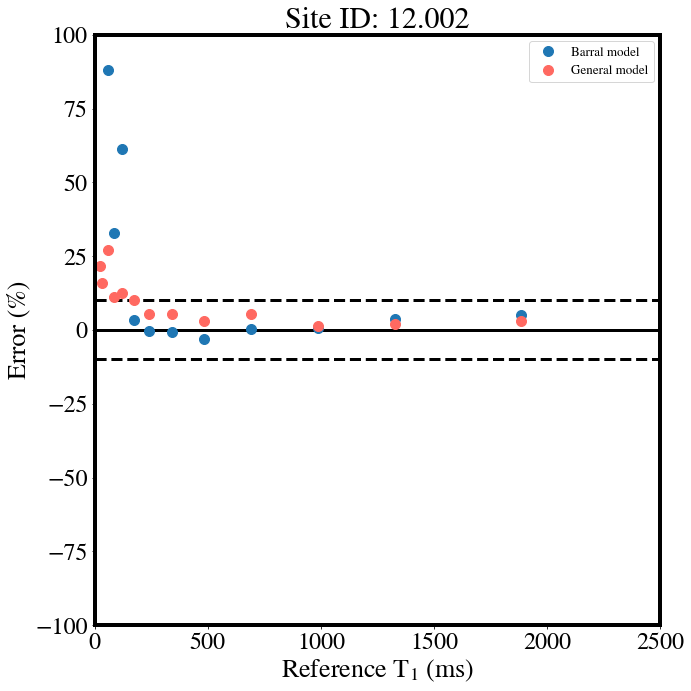

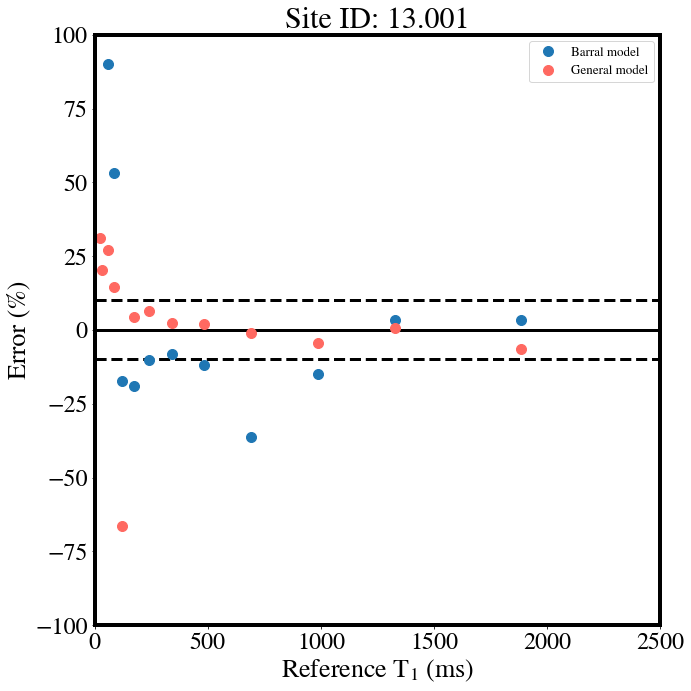

In [10]:
y_type = 'linear'
title = 'Error relative to reference'


for ii in range(dims[0]):
    
    fig_id = plot_single_scatter(x=ref_values[ii,:],
                                 y1=dataset_estimate_barral[ii,:],
                                 y2=dataset_estimate_general[ii,:],
                                 y1_std=dataset_std_barral[ii,:],
                                 y2_std=dataset_std_general[ii,:],
                                 title='Site ID: '+ str(index_id[ii]),
                                 x_label='Reference T$_1$ (ms)',
                                 y_label="Error (%)",
                                 file_prefix=('error_' + str(index_id[ii])),
                                 folder_path=output_folder,
                                 fig_id=fig_id,
                                 y_type='error_t1',
                                 labels=['Barral model', 'General model']
                                )